# MOD550 Project - Spatial Data Analysis and Modelling on Norwegian Windfarm Data

#### Import libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.optimize as so
import sys
import warnings
warnings.filterwarnings("ignore") #disable warnings (mostly related to fragmentation) to clean up the notebook

## Spatial Data Analysis

### Import Windfarm Data

In [74]:
vindkraft = pd.read_excel('./data/vindkraft.xlsx',usecols=['forventetProduksjon_Gwh','effekt_MW','totaltAntTurbiner','idriftDato','X','Y'])
vindkraft.drop(vindkraft[vindkraft['forventetProduksjon_Gwh'].isna()].index,axis=0,inplace=True)
vindkraft.drop(vindkraft[vindkraft['effekt_MW'].isna()].index,axis=0,inplace=True)
vindkraft.set_index(np.arange(0,len(vindkraft)),inplace=True)
print('Number of Datapoints:', len(vindkraft))
vindkraft.head()

Number of Datapoints: 263


effekt_MW  forventetProduksjon_Gwh idriftDato  totaltAntTurbiner  \
0        2.4                     8.16        NaT                NaN   
1      150.0                   510.00        NaT                NaN   
2      350.0                  1190.00        NaT                NaN   
3      130.2                   485.29 2021-07-29               31.0   
4      160.0                   544.00        NaT                NaN   

             X             Y  
0  -40480.2803  6.527760e+06  
1  -24464.1658  6.534317e+06  
2   58219.5512  6.995506e+06  
3  293077.7321  7.147981e+06  
4  541877.4412  7.677462e+06

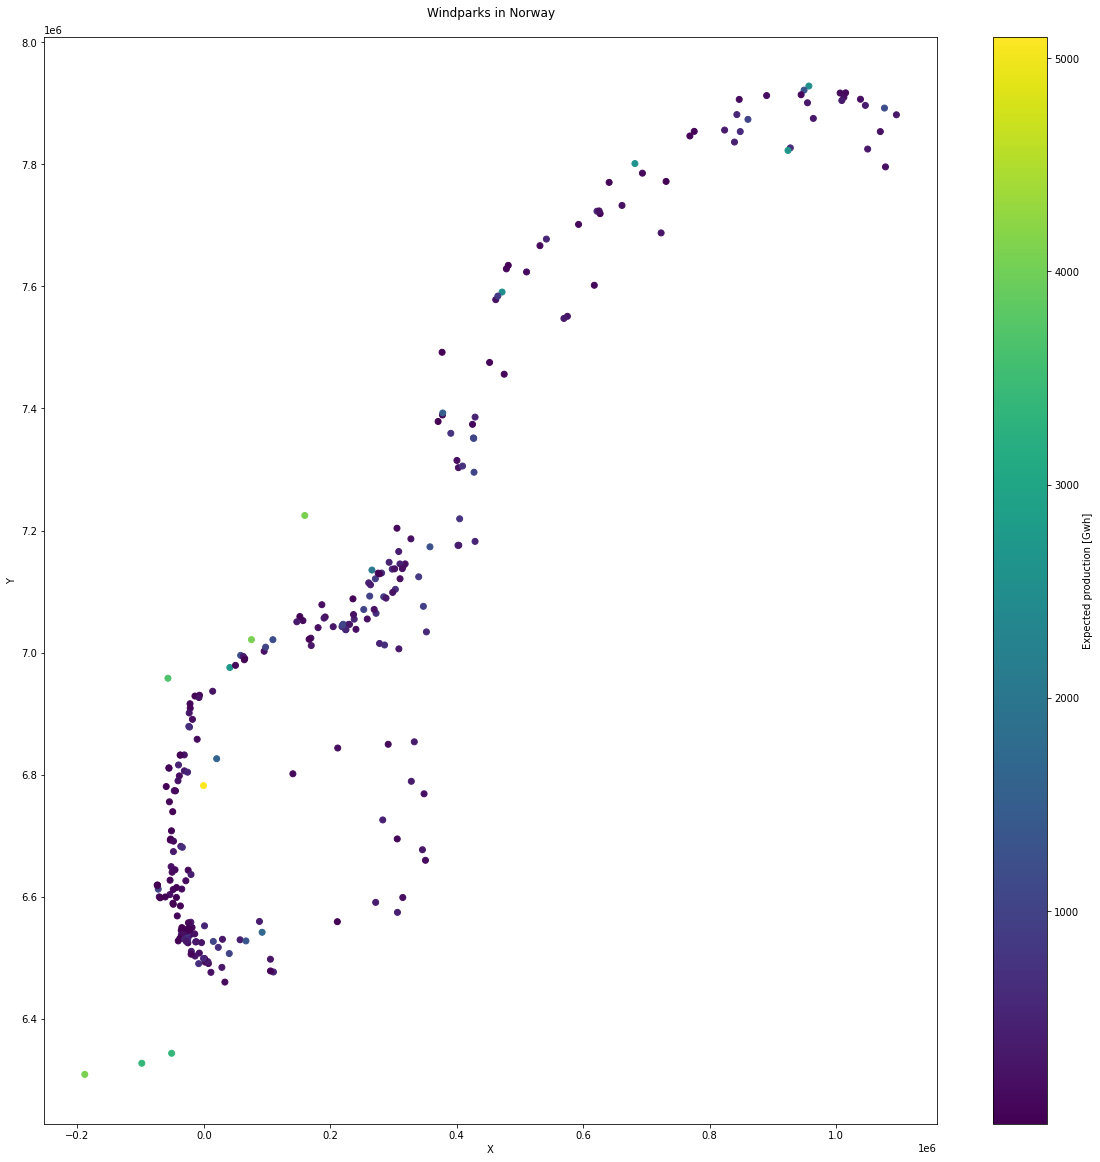

In [75]:
plt.figure(figsize=(20,20))

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')
plt.title('Windparks in Norway',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [76]:
vindkraft.drop(vindkraft[vindkraft['forventetProduksjon_Gwh']>=3000].index,axis=0,inplace=True) #only onshore windparks
vindkraft.set_index(np.arange(0,len(vindkraft)),inplace=True)
print('Number of Datapoints:', len(vindkraft))
vindkraft.head()

Number of Datapoints: 256


effekt_MW  forventetProduksjon_Gwh idriftDato  totaltAntTurbiner  \
0        2.4                     8.16        NaT                NaN   
1      150.0                   510.00        NaT                NaN   
2      350.0                  1190.00        NaT                NaN   
3      130.2                   485.29 2021-07-29               31.0   
4      160.0                   544.00        NaT                NaN   

             X             Y  
0  -40480.2803  6.527760e+06  
1  -24464.1658  6.534317e+06  
2   58219.5512  6.995506e+06  
3  293077.7321  7.147981e+06  
4  541877.4412  7.677462e+06

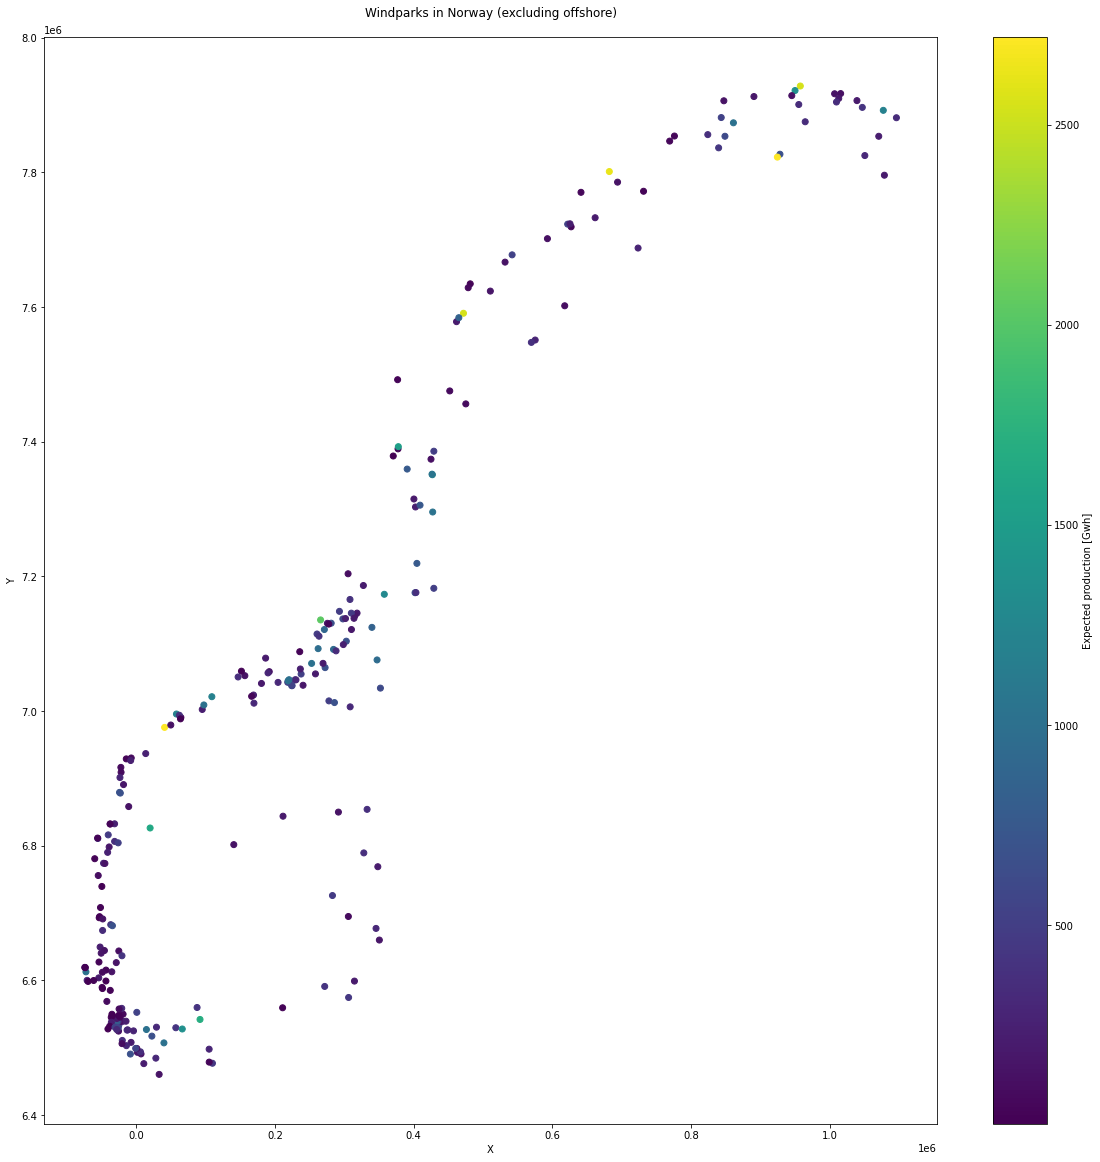

In [77]:
plt.figure(figsize=(20,20))

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')
plt.title('Windparks in Norway (excluding offshore)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

### De-Clustering

#### Define De-Clustering Grid and Find corresponding Gridcell for each Datapoint

In [78]:
DC_nx = 30
DC_ny = 30
DC_origin_x = vindkraft['X'].min()-1
DC_origin_y = vindkraft['Y'].min()-1
DC_X_array = np.linspace(DC_origin_x,vindkraft['X'].max(),DC_nx)
DC_Y_array = np.linspace(DC_origin_y,vindkraft['Y'].max(),DC_ny)

DC_X_ind = np.zeros(len(vindkraft))
DC_Y_ind = np.zeros(len(vindkraft))

vindkraft['DC_Cell_ind'] = np.zeros(len(vindkraft))

for i in range(len(vindkraft)):
    DC_X_ind[i] = np.where(vindkraft['X'][i]<=DC_X_array)[0][0]
    DC_Y_ind[i] = np.where(vindkraft['Y'][i]<=DC_Y_array)[0][0]
    vindkraft['DC_Cell_ind'][i] = DC_nx*DC_Y_ind[i]+DC_X_ind[i]
    
vindkraft.head()

effekt_MW  forventetProduksjon_Gwh idriftDato  totaltAntTurbiner  \
0        2.4                     8.16        NaT                NaN   
1      150.0                   510.00        NaT                NaN   
2      350.0                  1190.00        NaT                NaN   
3      130.2                   485.29 2021-07-29               31.0   
4      160.0                   544.00        NaT                NaN   

             X             Y  DC_Cell_ind  
0  -40480.2803  6.527760e+06         61.0  
1  -24464.1658  6.534317e+06         62.0  
2   58219.5512  6.995506e+06        334.0  
3  293077.7321  7.147981e+06        430.0  
4  541877.4412  7.677462e+06        766.0

#### Visualize De-Clustering Grid

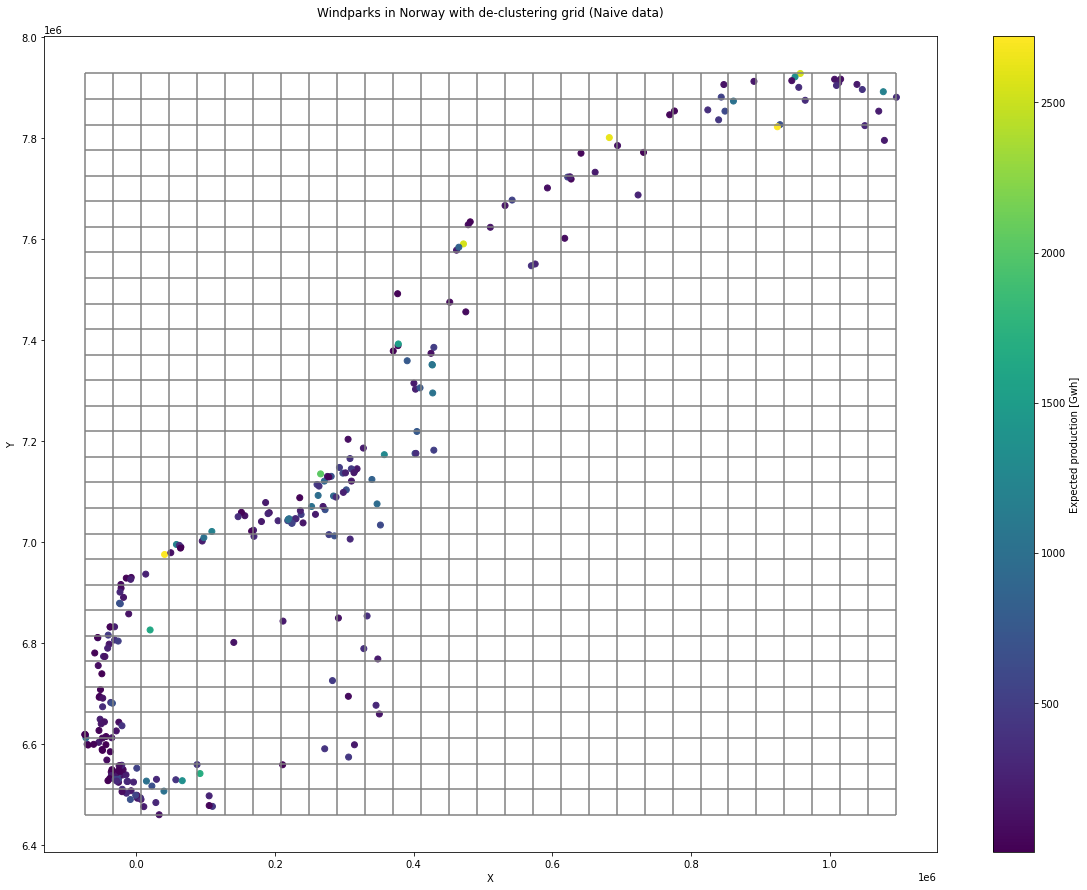

In [79]:
plt.figure(figsize=(20,15))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')
plt.title('Windparks in Norway with de-clustering grid (Naive data)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



#### Calculate Number of Datapoints per Cell and Number of occupied Cells

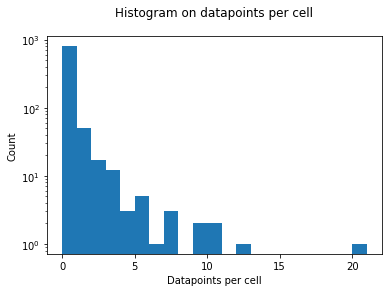

Number of occupied cells: 98


In [80]:
Num_data_in_cell = np.zeros(DC_nx*DC_ny)
for i in range(DC_nx*DC_ny):
    Num_data_in_cell[i] = len(np.where(vindkraft['DC_Cell_ind']==i)[0])

plt.hist(Num_data_in_cell,bins=int(np.max(Num_data_in_cell)))
plt.yscale('log')
plt.xlabel('Datapoints per cell')
plt.ylabel('Count')
plt.title('Histogram on datapoints per cell',pad=20)
plt.show()

n_occ = len(np.where(Num_data_in_cell>0)[0])
print('Number of occupied cells:' ,n_occ)

#### Calculate Cell Weights and apply to Datapoints

In [81]:
Cell_weight = 1/Num_data_in_cell*len(vindkraft)/n_occ

vindkraft['Weight'] = np.zeros(len(vindkraft))
for i in range(len(vindkraft)):
    vindkraft['Weight'][i] = Cell_weight[int(vindkraft['DC_Cell_ind'][i])]
vindkraft.head()

effekt_MW  forventetProduksjon_Gwh idriftDato  totaltAntTurbiner  \
0        2.4                     8.16        NaT                NaN   
1      150.0                   510.00        NaT                NaN   
2      350.0                  1190.00        NaT                NaN   
3      130.2                   485.29 2021-07-29               31.0   
4      160.0                   544.00        NaT                NaN   

             X             Y  DC_Cell_ind    Weight  
0  -40480.2803  6.527760e+06         61.0  0.435374  
1  -24464.1658  6.534317e+06         62.0  0.124393  
2   58219.5512  6.995506e+06        334.0  0.522449  
3  293077.7321  7.147981e+06        430.0  0.290249  
4  541877.4412  7.677462e+06        766.0  2.612245

In [82]:
vindkraft['weighted'] =vindkraft['Weight']*vindkraft['forventetProduksjon_Gwh']
vindkraft.head()

effekt_MW  forventetProduksjon_Gwh idriftDato  totaltAntTurbiner  \
0        2.4                     8.16        NaT                NaN   
1      150.0                   510.00        NaT                NaN   
2      350.0                  1190.00        NaT                NaN   
3      130.2                   485.29 2021-07-29               31.0   
4      160.0                   544.00        NaT                NaN   

             X             Y  DC_Cell_ind    Weight     weighted  
0  -40480.2803  6.527760e+06         61.0  0.435374     3.552653  
1  -24464.1658  6.534317e+06         62.0  0.124393    63.440233  
2   58219.5512  6.995506e+06        334.0  0.522449   621.714286  
3  293077.7321  7.147981e+06        430.0  0.290249   140.855147  
4  541877.4412  7.677462e+06        766.0  2.612245  1421.061224

#### Histograms on Naive- & Weighted Data and Weights

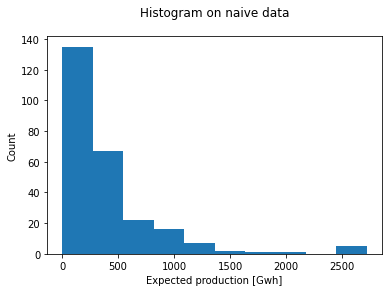

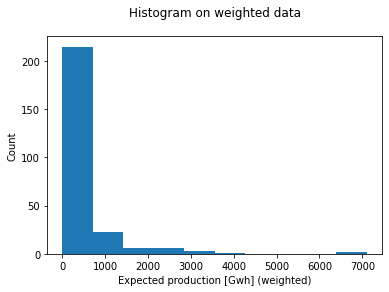

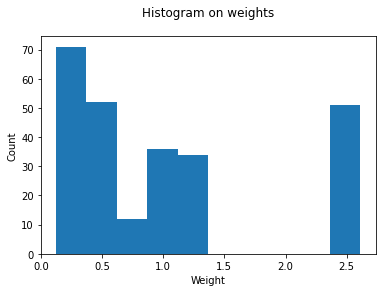

In [83]:
plt.hist(vindkraft['forventetProduksjon_Gwh'])
plt.xlabel('Expected production [Gwh]')
plt.ylabel('Count')
plt.title('Histogram on naive data',pad=20)
plt.show()

plt.hist(vindkraft['weighted'])
plt.xlabel('Expected production [Gwh] (weighted)')
plt.ylabel('Count')
plt.title('Histogram on weighted data',pad=20)
plt.show()

plt.hist(vindkraft['Weight'])
plt.xlabel('Weight')
plt.ylabel('Count')
plt.title('Histogram on weights',pad=20)
plt.show()

#### Visualize Weights and Weighted Data

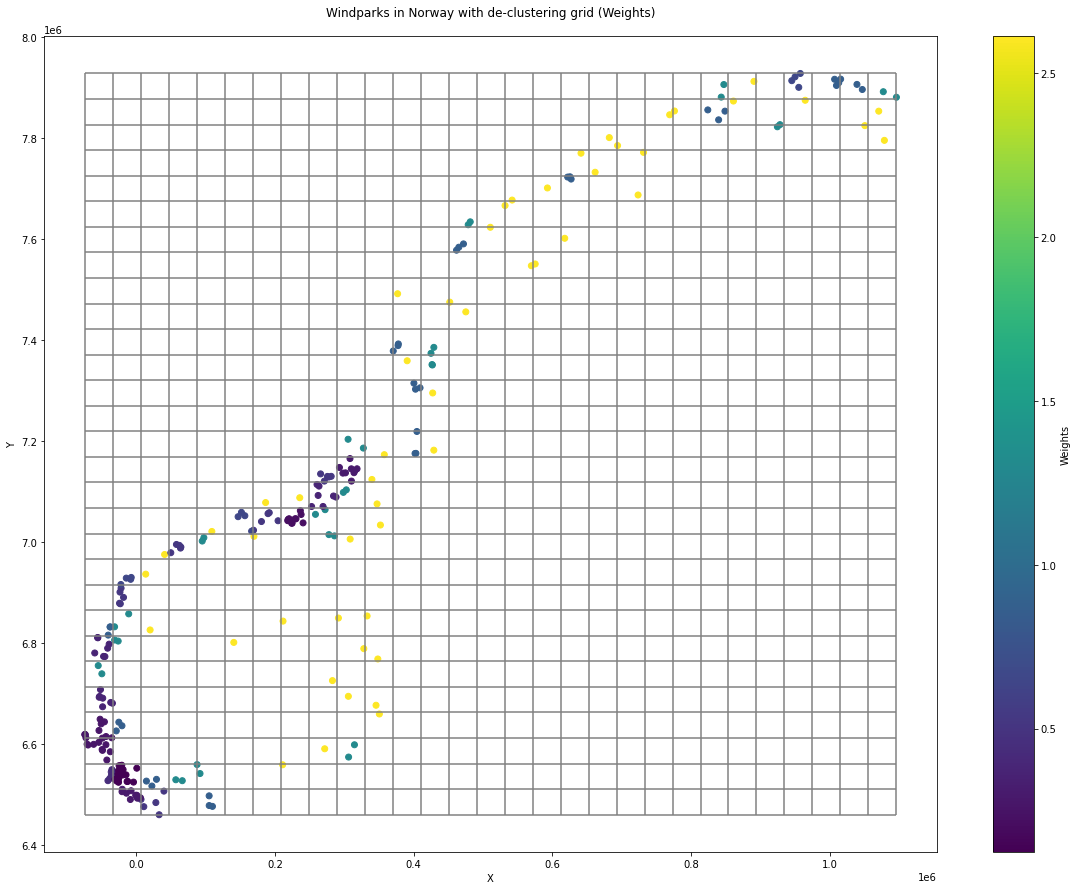

In [84]:
plt.figure(figsize=(20,15))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['Weight'])
plt.colorbar(label='Weights')
plt.title('Windparks in Norway with de-clustering grid (Weights)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



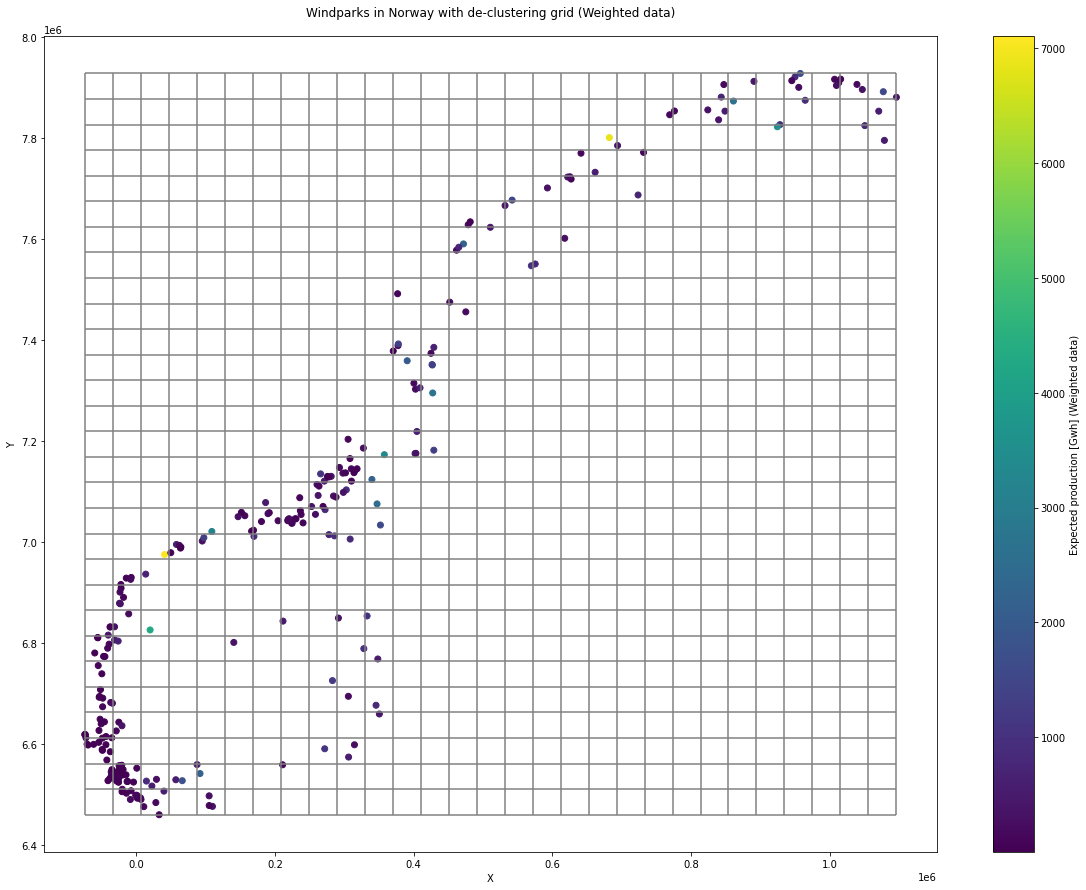

In [85]:
plt.figure(figsize=(20,15))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['weighted'])
plt.colorbar(label='Expected production [Gwh] (Weighted data)')
plt.title('Windparks in Norway with de-clustering grid (Weighted data)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



### Import Wind and Terrain Data, match up with Windfarm Locations and Visualize

In [86]:
avg_wind_50m_llcorner_x = -286105.104913711
avg_wind_50m_llcorner_y = 6278074.033788681
avg_wind_50m_cellsize = 1000
avg_wind_50m_len_x = 1608
avg_wind_50m_len_y = 2214
avg_wind_50m_offset_y = -60000
avg_wind_50m_indices = np.flip(np.arange(avg_wind_50m_llcorner_y+avg_wind_50m_offset_y,avg_wind_50m_cellsize*avg_wind_50m_len_y+avg_wind_50m_llcorner_y+avg_wind_50m_offset_y,avg_wind_50m_cellsize))
avg_wind_50m = pd.read_csv('./data/Vindressurs/Vindressurs_Gjennomsnittsvind_50m.asc',sep=' ',skiprows=6,names=np.arange(avg_wind_50m_llcorner_x,avg_wind_50m_len_x*avg_wind_50m_cellsize+avg_wind_50m_llcorner_x,avg_wind_50m_cellsize))
avg_wind_50m.set_index(avg_wind_50m_indices,inplace=True)
avg_wind_50m.head()




-2.861051e+05  -2.851051e+05  -2.841051e+05  -2.831051e+05  \
8.431074e+06           -1.0           -1.0           -1.0           -1.0   
8.430074e+06           -1.0           -1.0           -1.0           -1.0   
8.429074e+06           -1.0           -1.0           -1.0           -1.0   
8.428074e+06           -1.0           -1.0           -1.0           -1.0   
8.427074e+06           -1.0           -1.0           -1.0           -1.0   

              -2.821051e+05  -2.811051e+05  -2.801051e+05  -2.791051e+05  \
8.431074e+06           -1.0           -1.0           -1.0           -1.0   
8.430074e+06           -1.0           -1.0           -1.0           -1.0   
8.429074e+06           -1.0           -1.0           -1.0           -1.0   
8.428074e+06           -1.0           -1.0           -1.0           -1.0   
8.427074e+06           -1.0           -1.0           -1.0           -1.0   

              -2.781051e+05  -2.771051e+05  ...   1.311895e+06   1.312895e+06  \
8.431074e+06           -1.0           -1.0  ...           -1.0           -1.0   
8.430074e+06           -1.0           -1.0  ...           -1.0           -1.0   
8.429074e+06           -1.0           -1.0  ...           -1.0           -1.0   
8.428074e+06           -1.0           -1.0  ...           -1.0           -1.0   
8.427074e+06           -1.0           -1.0  ...           -1.0           -1.0   

               1.313895e+06   1.314895e+06   1.315895e+06   1.316895e+06  \
8.431074e+06           -1.0           -1.0           -1.0           -1.0   
8.430074e+06           -1.0           -1.0           -1.0           -1.0   
8.429074e+06           -1.0           -1.0           -1.0           -1.0   
8.428074e+06           -1.0           -1.0           -1.0           -1.0   
8.427074e+06           -1.0           -1.0           -1.0           -1.0   

               1.317895e+06   1.318895e+06   1.319895e+06   1.320895e+06  
8.431074e+06           -1.0           -1.0           -1.0           -1.0  
8.430074e+06           -1.0           -1.0           -1.0           -1.0  
8.429074e+06           -1.0           -1.0           -1.0           -1.0  
8.428074e+06           -1.0           -1.0           -1.0           -1.0  
8.427074e+06           -1.0           -1.0           -1.0           -1.0  

[5 rows x 1608 columns]

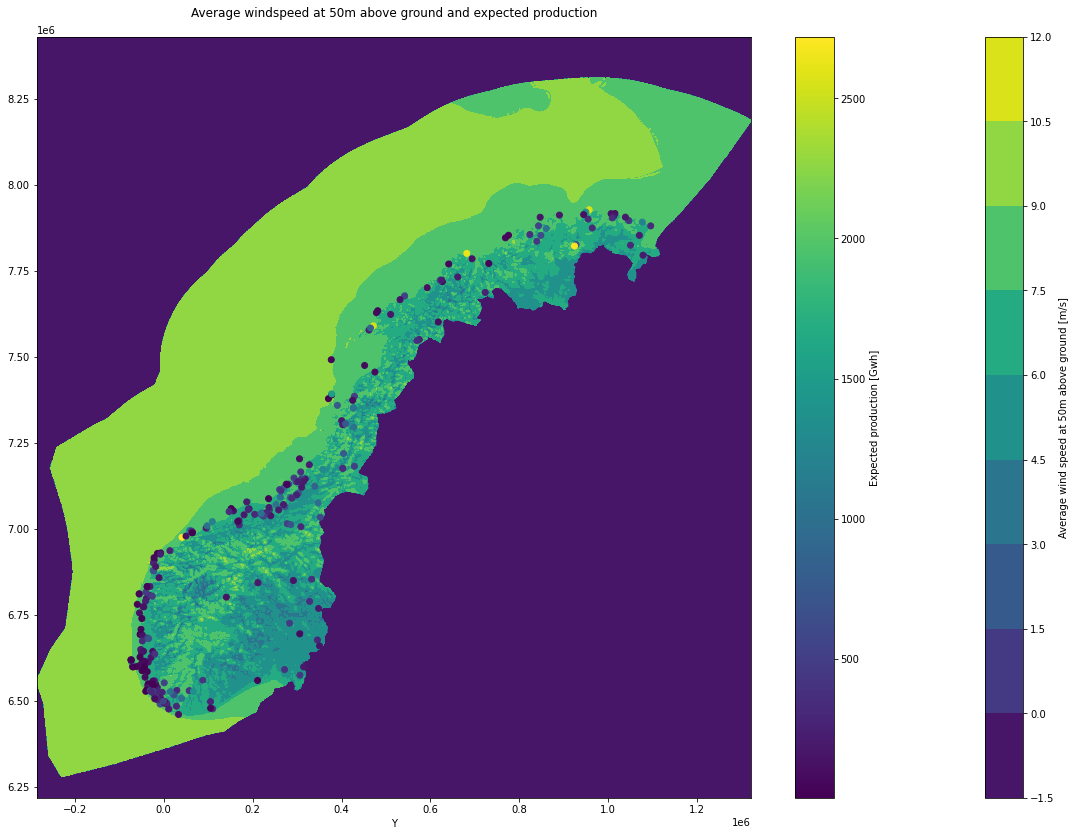

In [87]:
plt.figure(figsize=(20,14))
plt.contourf(avg_wind_50m.columns,avg_wind_50m.index, np.array(avg_wind_50m))
plt.colorbar(label='Average wind speed at 50m above ground [m/s]')

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')

plt.xlabel('X')
plt.xlabel('Y')
plt.title('Average windspeed at 50m above ground and expected production',pad=20)

plt.show()

In [88]:
Terrengkompleksitet_llcorner_x = -106000
Terrengkompleksitet_llcorner_y = 6435000
Terrengkompleksitet_cellsize = 200
Terrengkompleksitet_len_x = 6185
Terrengkompleksitet_len_y = 7552
Terrengkompleksitet_offset_y = 0
Terrengkompleksitet_indices = np.flip(np.arange(Terrengkompleksitet_llcorner_y+Terrengkompleksitet_offset_y,Terrengkompleksitet_cellsize*Terrengkompleksitet_len_y+Terrengkompleksitet_llcorner_y+Terrengkompleksitet_offset_y,Terrengkompleksitet_cellsize))
Terrengkompleksitet = pd.read_csv('./data/Vindressurs/Vindressurs_Terrengkompleksitet.asc',sep=' ',skiprows=6,names=np.arange(Terrengkompleksitet_llcorner_x,Terrengkompleksitet_len_x*Terrengkompleksitet_cellsize+Terrengkompleksitet_llcorner_x,Terrengkompleksitet_cellsize))
Terrengkompleksitet.set_index(Terrengkompleksitet_indices,inplace=True)
Terrengkompleksitet.head()

-106000   -105800   -105600   -105400   -105200   -105000   -104800   \
7945200      -1.0        -1        -1        -1        -1        -1        -1   
7945000      -1.0        -1        -1        -1        -1        -1        -1   
7944800      -1.0        -1        -1        -1        -1        -1        -1   
7944600      -1.0        -1        -1        -1        -1        -1        -1   
7944400      -1.0        -1        -1        -1        -1        -1        -1   

         -104600   -104400   -104200   ...   1129000   1129200   1129400  \
7945200        -1        -1        -1  ...        -1        -1        -1   
7945000        -1        -1        -1  ...        -1        -1        -1   
7944800        -1        -1        -1  ...        -1        -1        -1   
7944600        -1        -1        -1  ...        -1        -1        -1   
7944400        -1        -1        -1  ...        -1        -1        -1   

          1129600   1129800   1130000   1130200   1130400   1130600   1130800  
7945200        -1        -1        -1        -1        -1        -1        -1  
7945000        -1        -1        -1        -1        -1        -1        -1  
7944800        -1        -1        -1        -1        -1        -1        -1  
7944600        -1        -1        -1        -1        -1        -1        -1  
7944400        -1        -1        -1        -1        -1        -1        -1  

[5 rows x 6185 columns]

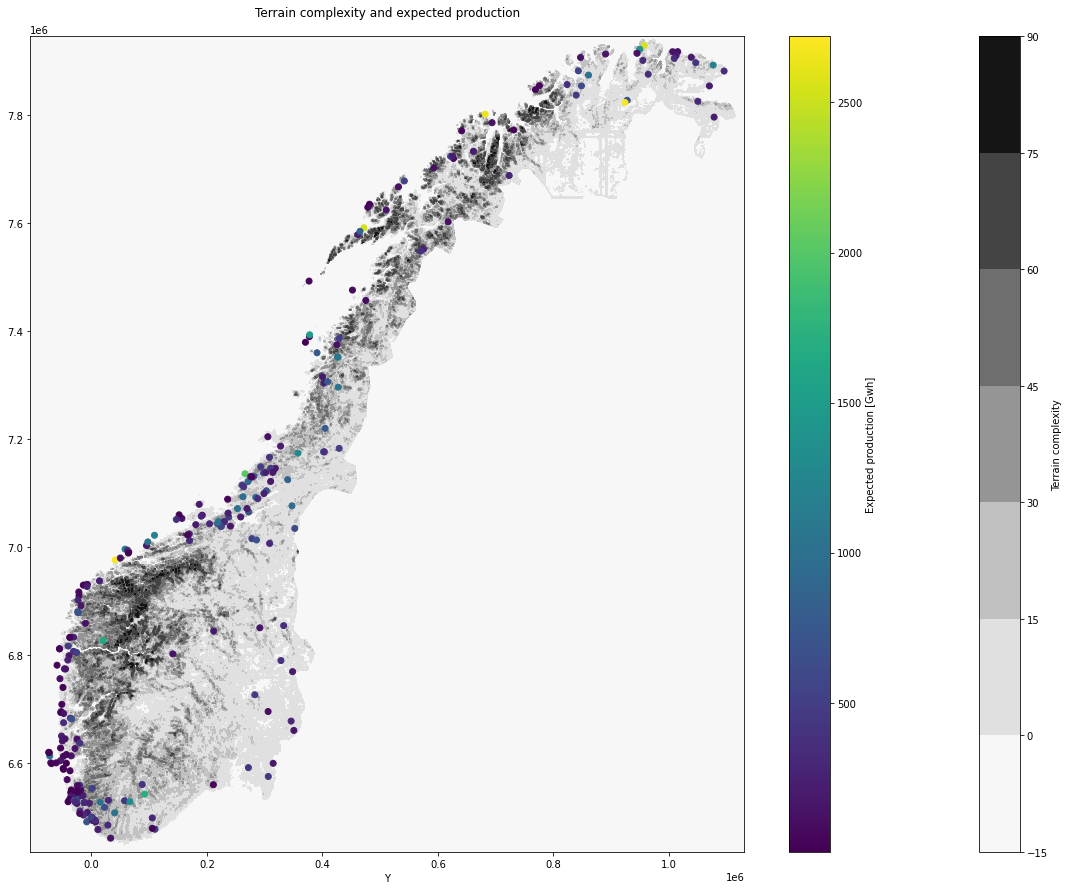

In [89]:
plt.figure(figsize=(20,15))
plt.contourf(Terrengkompleksitet.columns,Terrengkompleksitet.index, np.array(Terrengkompleksitet),cmap='Greys')
plt.colorbar(label='Terrain complexity')

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')

plt.xlabel('X')
plt.xlabel('Y')
plt.title('Terrain complexity and expected production',pad=20)

plt.show()

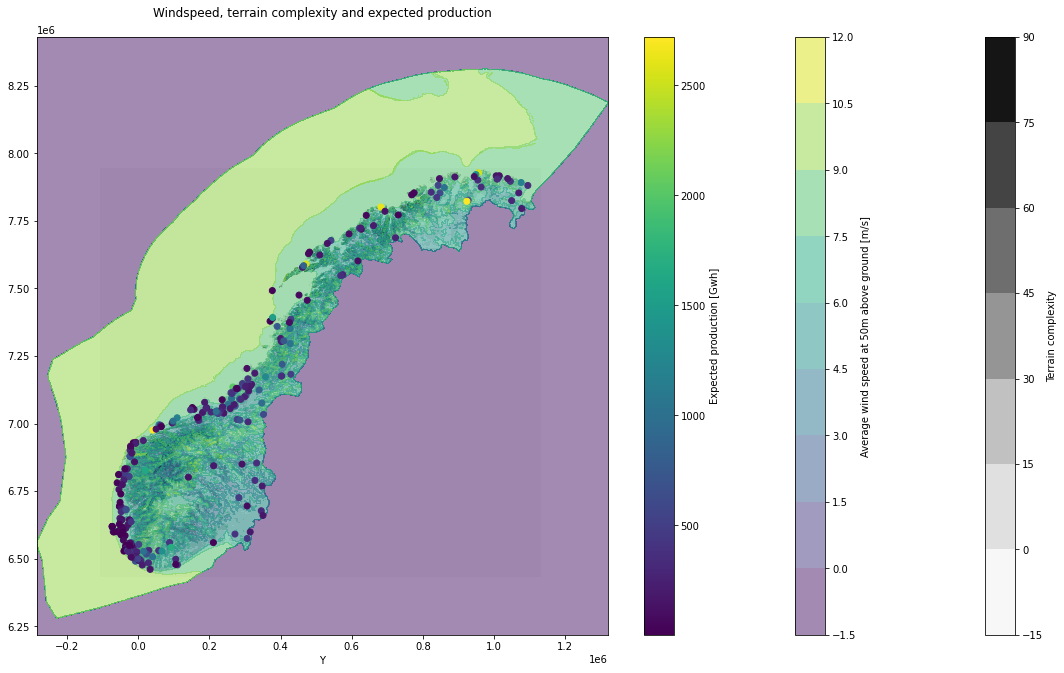

In [90]:
plt.figure(figsize=(20,11))

plt.contourf(Terrengkompleksitet.columns,Terrengkompleksitet.index, np.array(Terrengkompleksitet),cmap='Greys')
plt.colorbar(label='Terrain complexity')

plt.contourf(avg_wind_50m.columns,avg_wind_50m.index, np.array(avg_wind_50m),alpha=0.5)
plt.colorbar(label='Average wind speed at 50m above ground [m/s]')

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')

plt.xlabel('X')
plt.xlabel('Y')
plt.title('Windspeed, terrain complexity and expected production',pad=20)

plt.show()

### Sample Wind and Terrain Data at Windfarm Locations

In [91]:
avg_wind_50m_array = avg_wind_50m.to_numpy()
avg_wind_50m_x = np.array(avg_wind_50m.columns)
avg_wind_50m_y = np.array(avg_wind_50m.index)
vindkraft['avg_windspeed_50m'] = np.zeros(len(vindkraft))
for i in range(len(vindkraft)):
    x_ind = np.where(avg_wind_50m_x<=vindkraft['X'][i]+avg_wind_50m_cellsize/2)[0][-1]
    y_ind = np.where(avg_wind_50m_y<=vindkraft['Y'][i]+avg_wind_50m_cellsize/2)[0][0]
    vindkraft['avg_windspeed_50m'][i] = avg_wind_50m_array[y_ind,x_ind]


In [92]:
Terrengkompleksitet_array = Terrengkompleksitet.to_numpy()
Terrengkompleksitet_x = np.array(Terrengkompleksitet.columns)
Terrengkompleksitet_y = np.array(Terrengkompleksitet.index)
vindkraft['Terrengkompleksitet'] = np.zeros(len(vindkraft))
for i in range(len(vindkraft)):
    x_ind = np.where(Terrengkompleksitet_x<=vindkraft['X'][i]+Terrengkompleksitet_cellsize/2)[0][-1]
    y_ind = np.where(Terrengkompleksitet_y<=vindkraft['Y'][i]+Terrengkompleksitet_cellsize/2)[0][0]
    vindkraft['Terrengkompleksitet'][i] = Terrengkompleksitet_array[y_ind,x_ind]


### Define Collumns for Data Analysis

In [93]:
cols = ['Terrengkompleksitet','avg_windspeed_50m','effekt_MW','forventetProduksjon_Gwh']
col_labels_title = ['Terraincomplexity','Average windspeed 50m above ground','Licensed power','Expected production']
col_labels_axis = ['Terraincomplexity','Windspeed [m/s]','Licensed power [MW]','Expected production [GWh]']

### Initial Data Visualisation

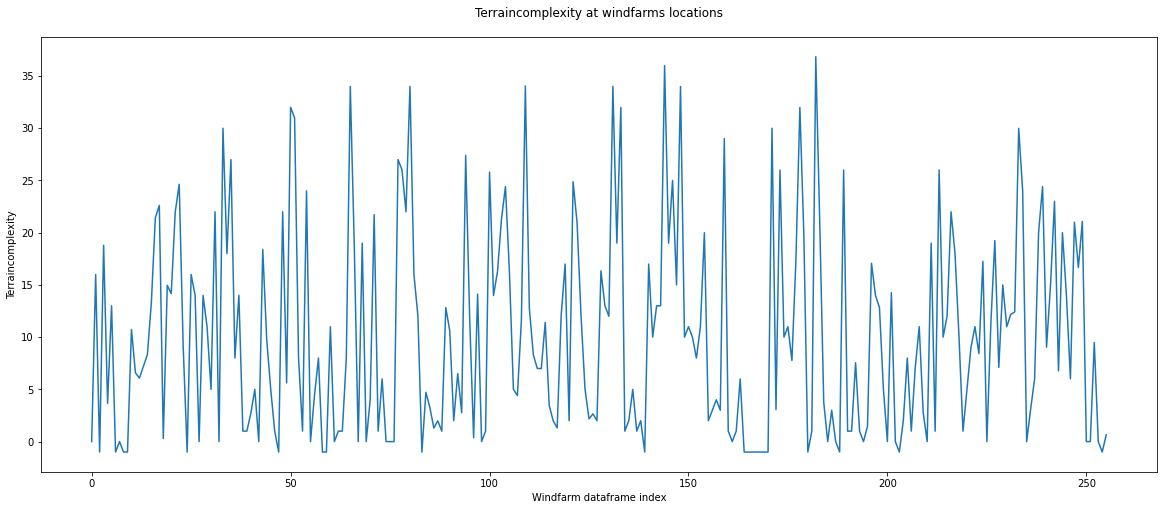

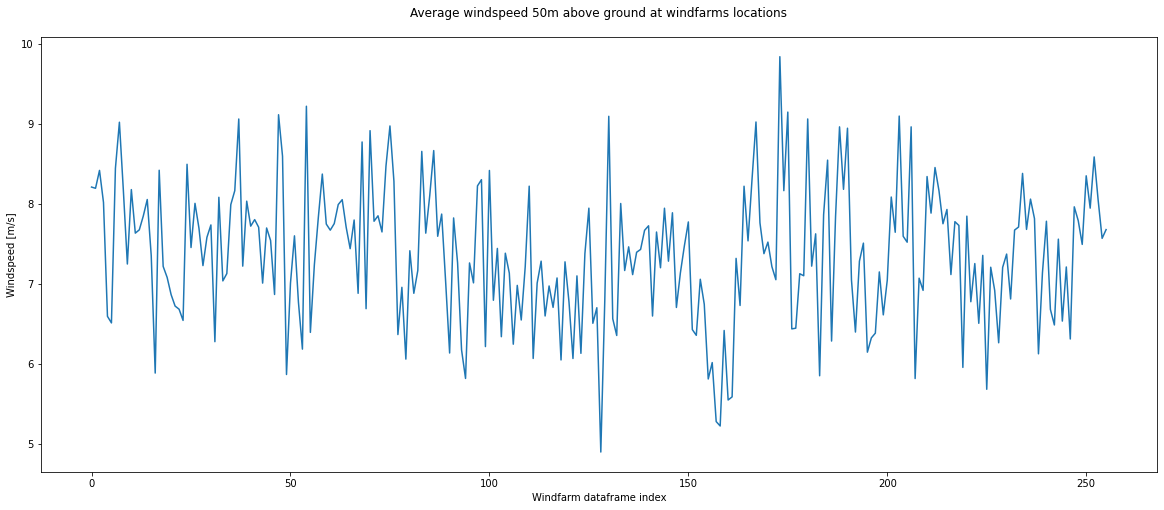

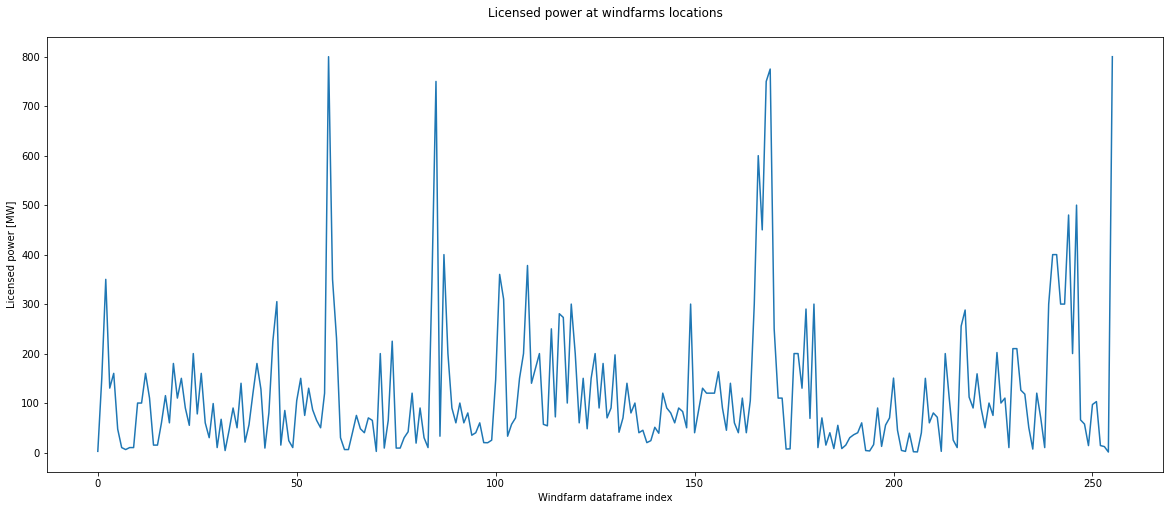

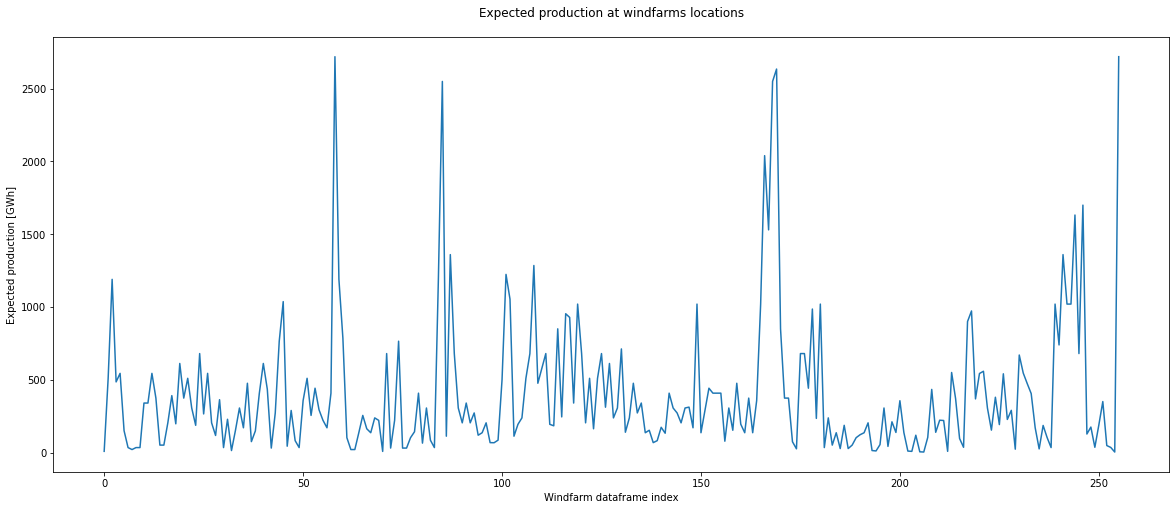

In [94]:
for col_num, col in enumerate(cols):
    plt.figure(figsize = (20,8))
    plt.plot(vindkraft[col])
    plt.title(col_labels_title[col_num]+' at windfarms locations',pad=20)
    plt.xlabel('Windfarm dataframe index')
    plt.ylabel(col_labels_axis[col_num])
    plt.show()

### Scatterplots

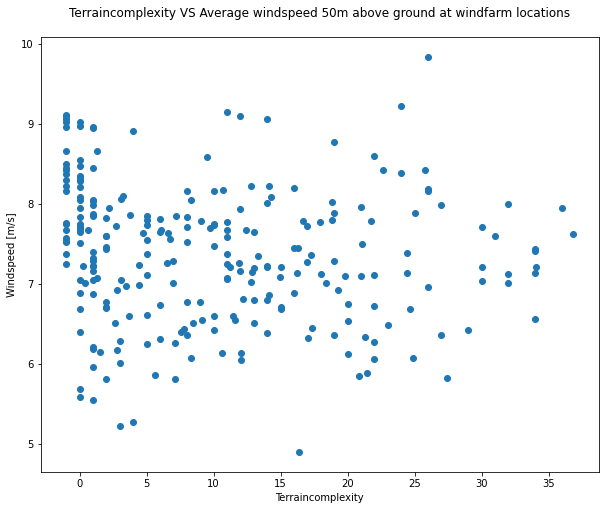

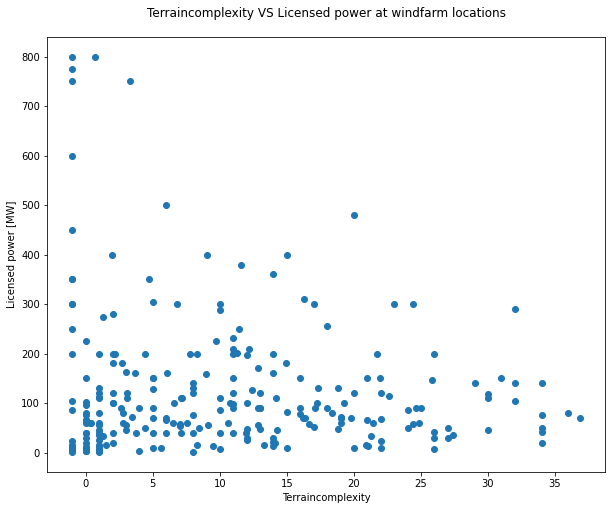

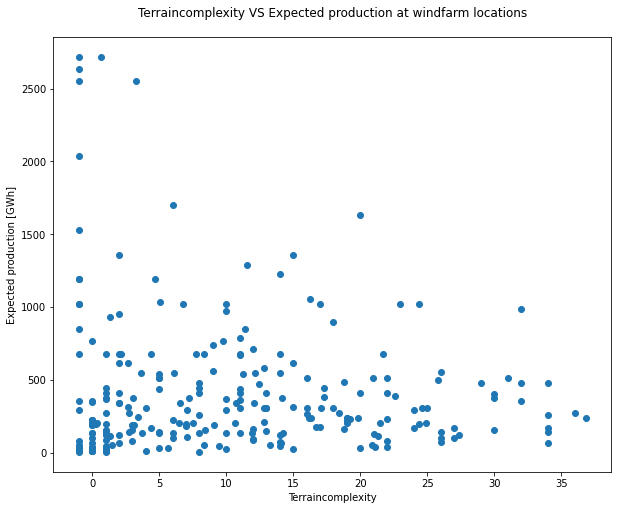

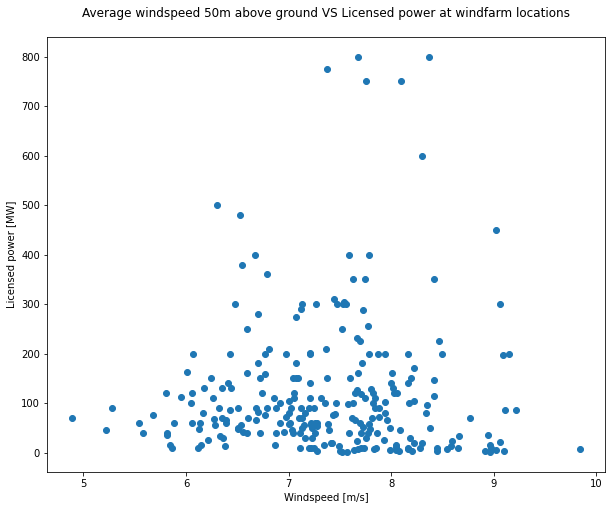

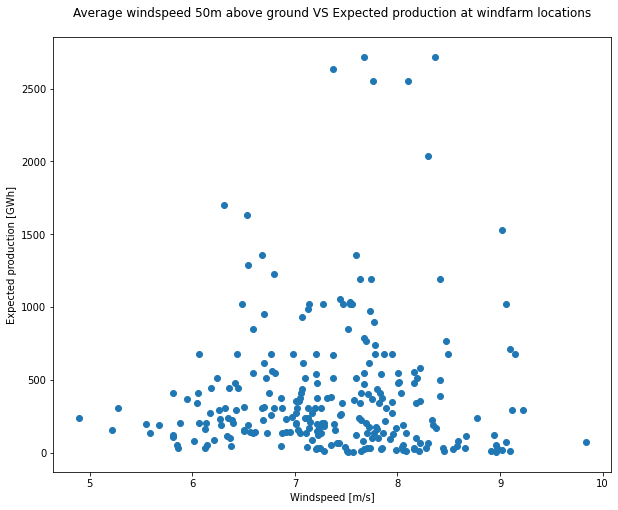

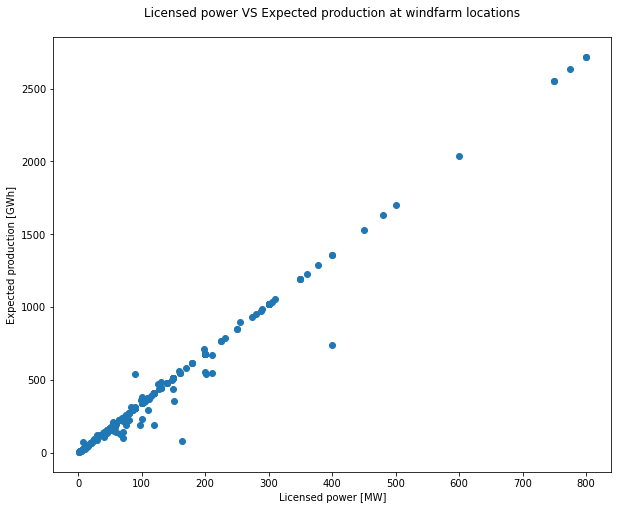

In [95]:
for col1_num, col1 in enumerate(cols):
    for col2_num, col2 in enumerate(cols):
        if col1_num < col2_num:
            plt.figure(figsize = (10,8))
            plt.scatter(vindkraft[col1],vindkraft[col2]) 
            plt.title(col_labels_title[col1_num] +' VS '+ col_labels_title[col2_num] +' at windfarm locations',pad=20)
            plt.xlabel(col_labels_axis[col1_num])
            plt.ylabel(col_labels_axis[col2_num])
            plt.show()

### Advanced Scatterplots with Colorcoding

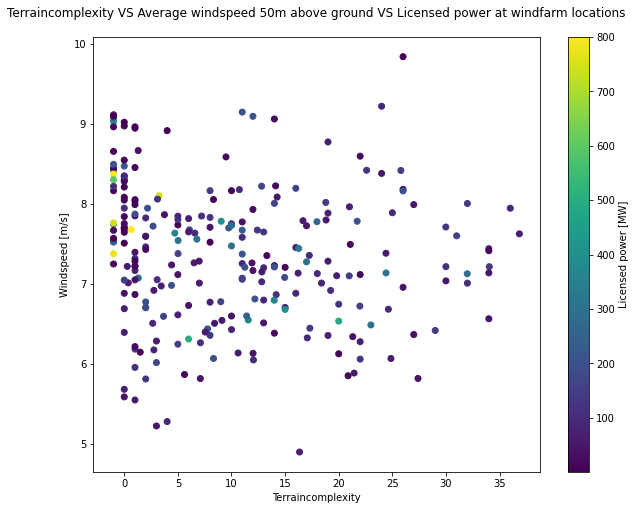

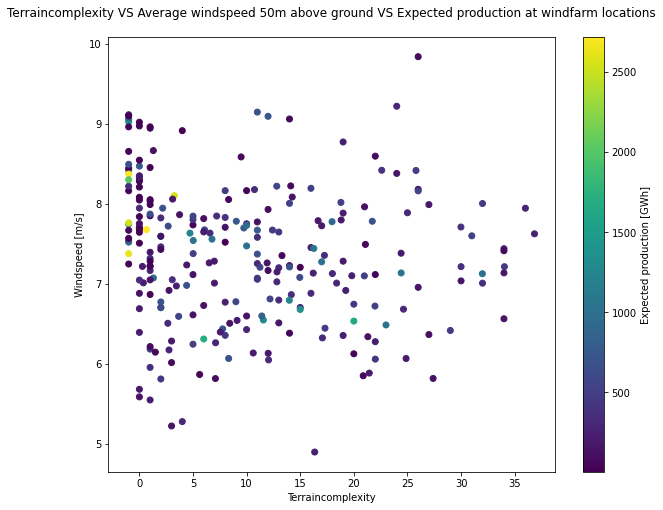

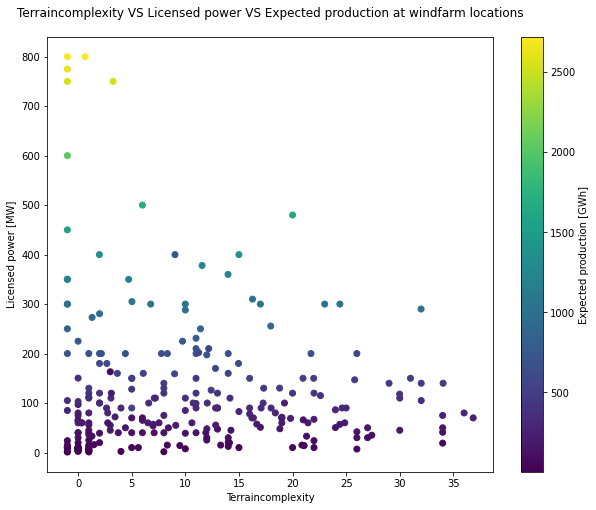

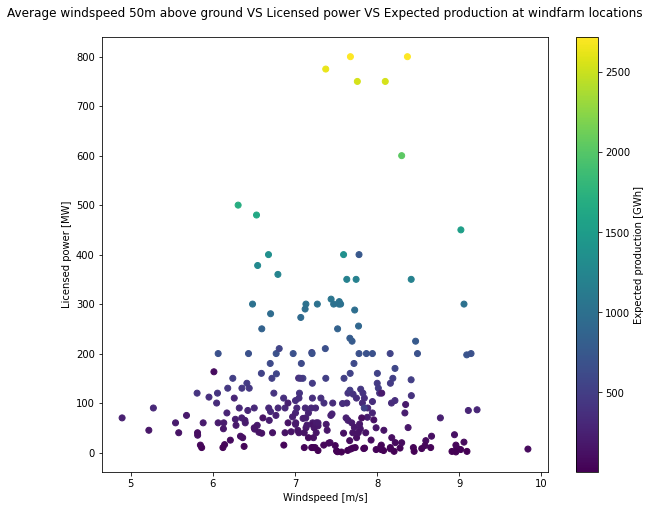

In [96]:
for col1_num, col1 in enumerate(cols):
    for col2_num, col2 in enumerate(cols):
        for col3_num, col3 in enumerate(cols):
            if col1_num < col2_num:
                if col2_num < col3_num:
                    plt.figure(figsize = (10,8))
                    plt.scatter(vindkraft[col1],vindkraft[col2],c=vindkraft[col3]) 
                    plt.title(col_labels_title[col1_num] +' VS '+ col_labels_title[col2_num] +' VS '+col_labels_title[col3_num]+' at windfarm locations',pad=20)
                    plt.xlabel(col_labels_axis[col1_num])
                    plt.ylabel(col_labels_axis[col2_num])
                    plt.colorbar(label=col_labels_axis[col3_num])
                    plt.show()

#### Relationship between Licensed Power and Expected Production

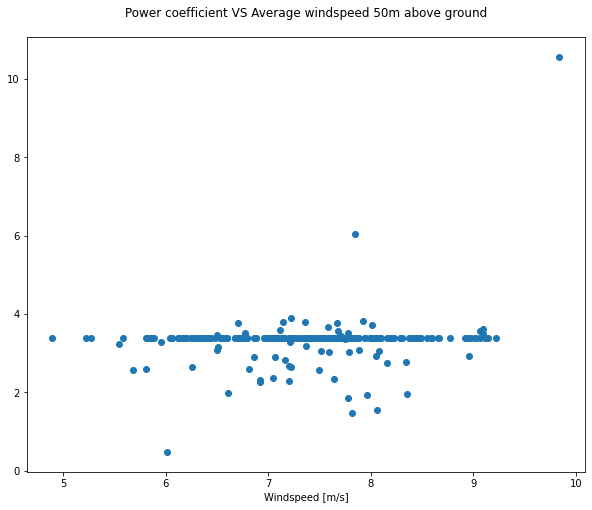

In [97]:
vindkraft['power_coeff']=vindkraft['forventetProduksjon_Gwh']/vindkraft['effekt_MW']
plt.figure(figsize = (10,8))
plt.scatter(vindkraft['avg_windspeed_50m'],vindkraft['power_coeff'])
plt.title('Power coefficient VS '+col_labels_title[1],pad=20)
plt.xlabel(col_labels_axis[1])
plt.show()

### Histograms

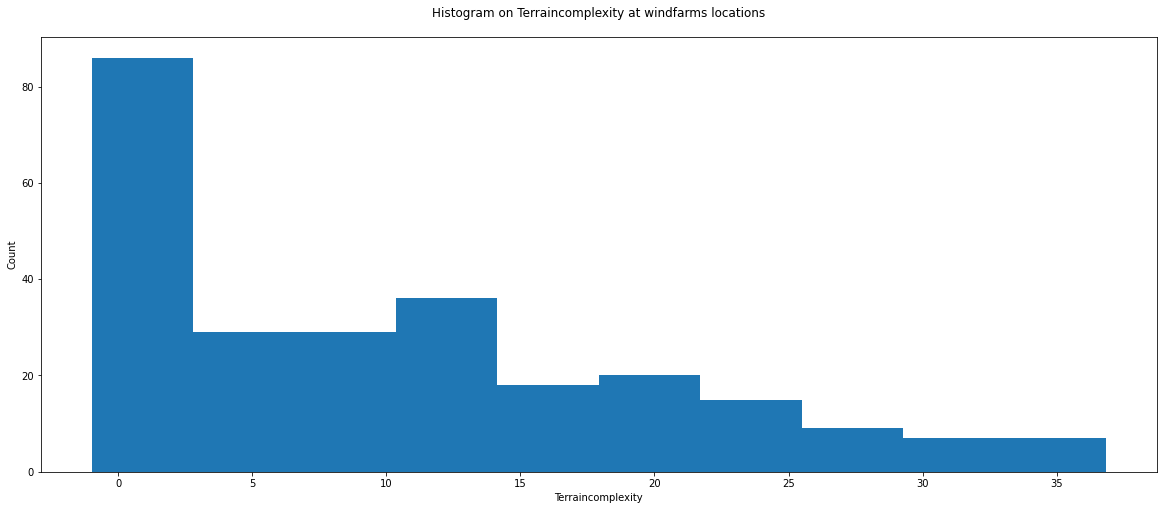

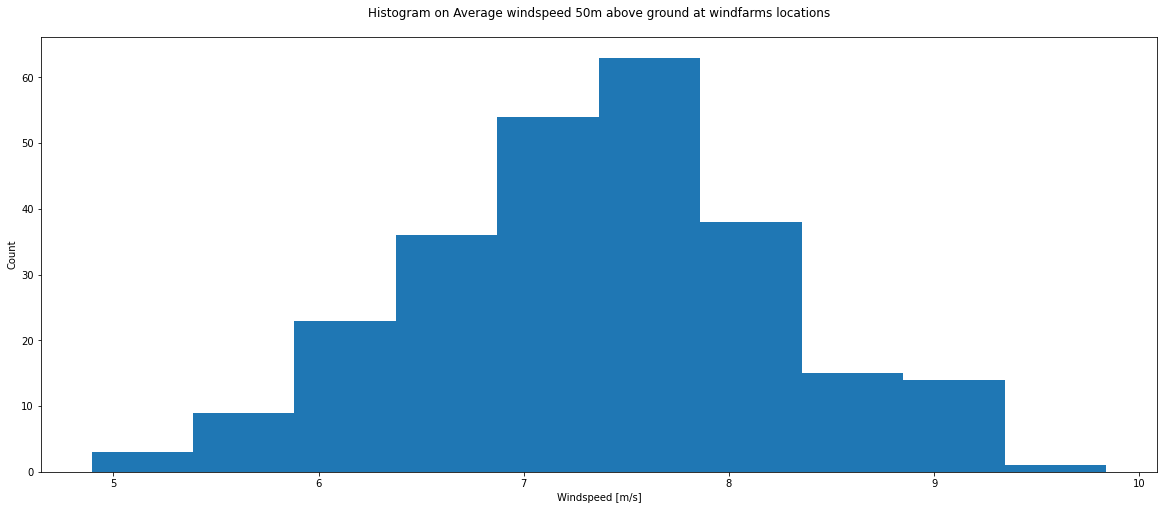

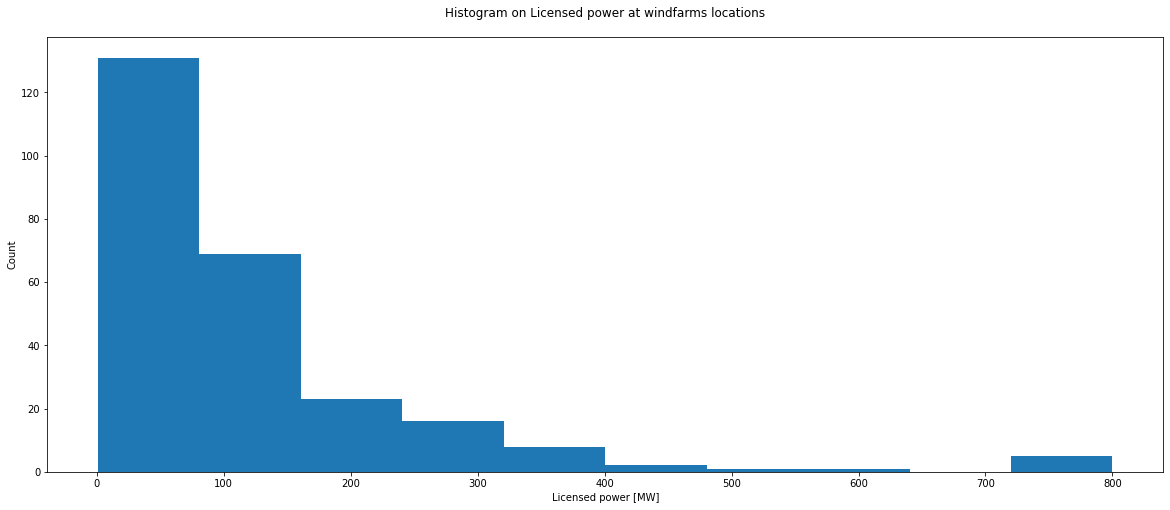

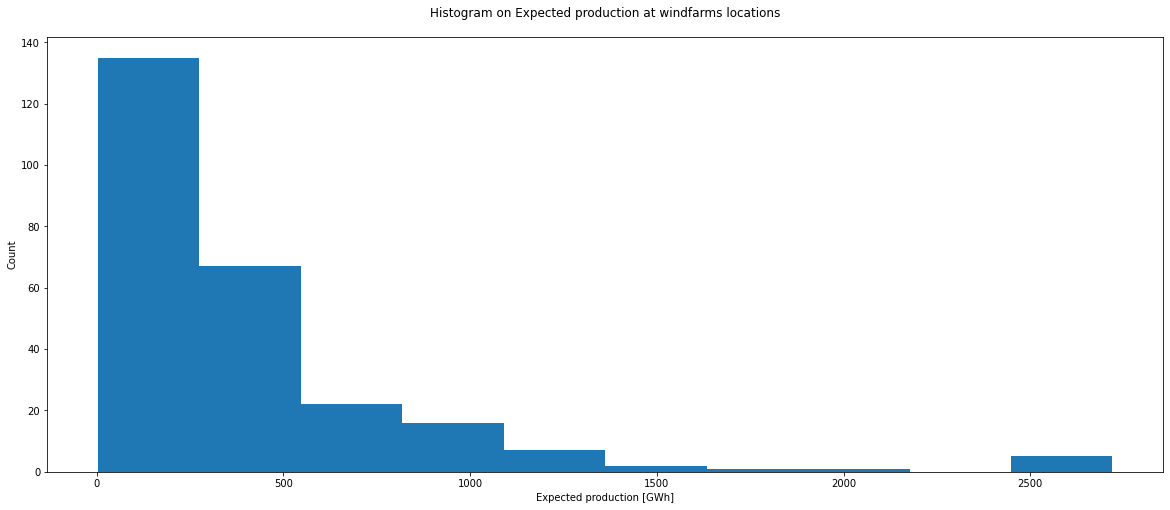

In [98]:
for col_num, col in enumerate(cols):
    plt.figure(figsize = (20,8))
    plt.hist(vindkraft[col])
    plt.title('Histogram on ' + col_labels_title[col_num]+' at windfarms locations',pad=20)
    plt.xlabel(col_labels_axis[col_num])
    plt.ylabel('Count')
    plt.show()

### 2D Histograms

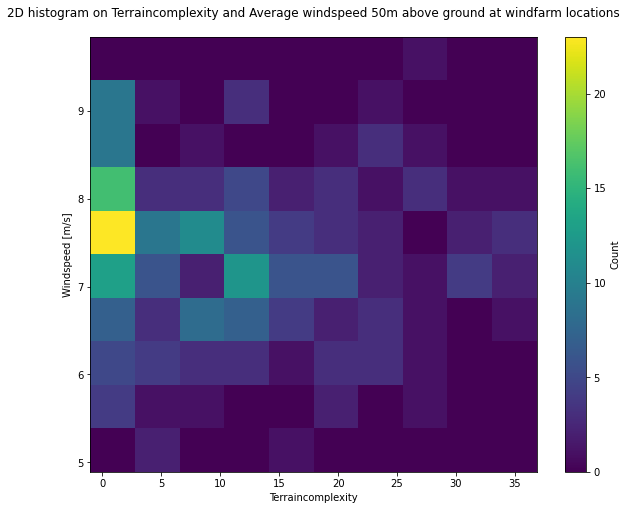

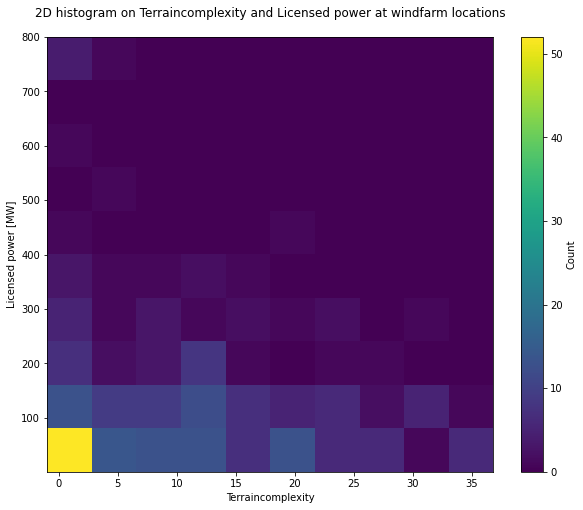

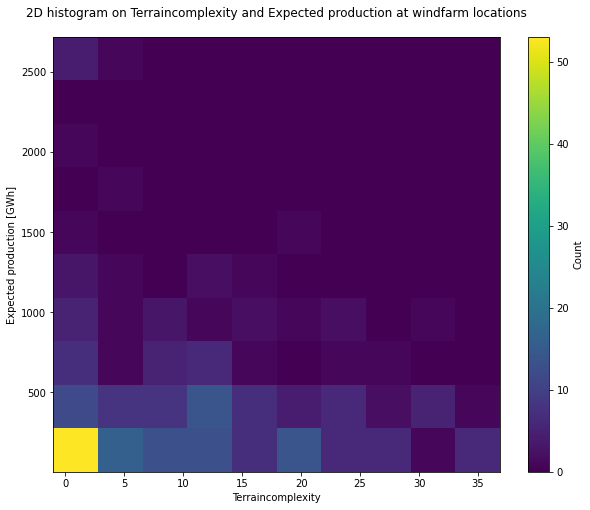

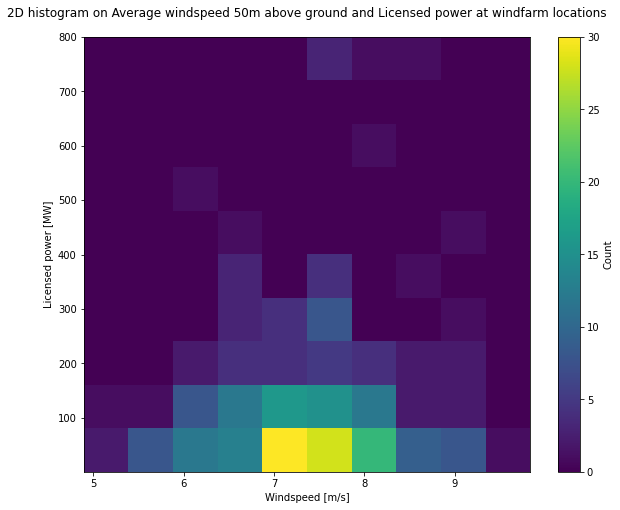

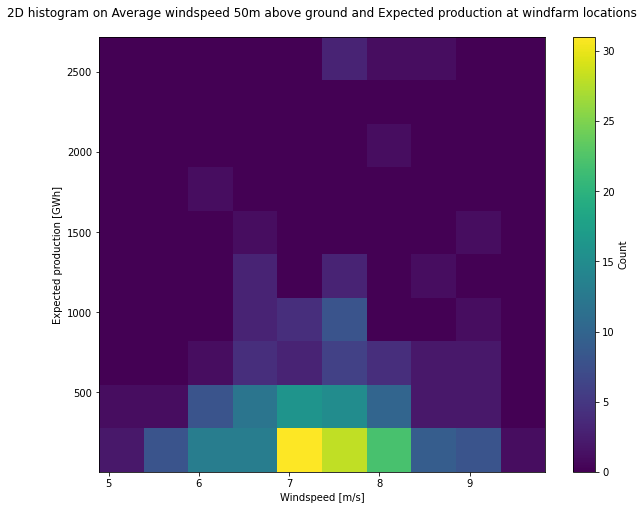

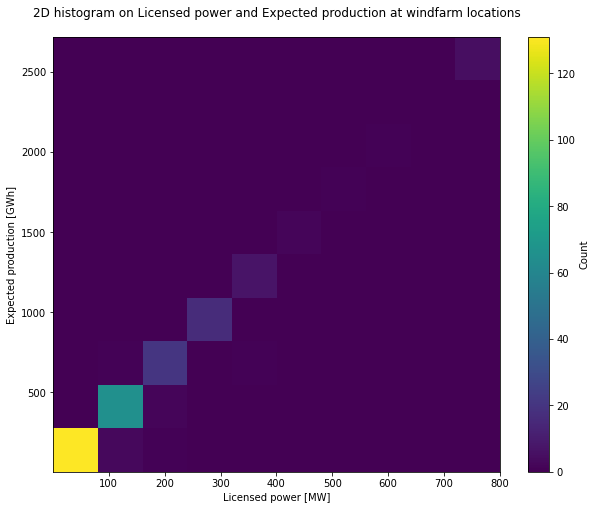

In [99]:
for col1_num, col1 in enumerate(cols):
    for col2_num, col2 in enumerate(cols):
        if col1_num < col2_num:
            plt.figure(figsize = (10,8))
            plt.hist2d(vindkraft[col1],vindkraft[col2]) 
            plt.colorbar(label='Count')
            plt.title('2D histogram on '+ col_labels_title[col1_num] +' and '+ col_labels_title[col2_num] +' at windfarm locations',pad=20)
            plt.xlabel(col_labels_axis[col1_num])
            plt.ylabel(col_labels_axis[col2_num])
            plt.show()

### Covariance and Correlation Matrix

In [100]:
cov = np.cov((vindkraft['Terrengkompleksitet'],vindkraft['avg_windspeed_50m'],vindkraft['forventetProduksjon_Gwh'],vindkraft['effekt_MW']))
corr = np.corrcoef((vindkraft['Terrengkompleksitet'],vindkraft['avg_windspeed_50m'],vindkraft['forventetProduksjon_Gwh'],vindkraft['effekt_MW']))

print('Covariance Matrix:',cov)
print('Correlation Matrix:',corr)

Covariance Matrix: [[ 9.54167035e+01 -1.02834568e+00 -3.64355993e+02 -1.16568780e+02]
 [-1.02834568e+00  7.33713719e-01  1.92949116e+01  4.77065107e+00]
 [-3.64355993e+02  1.92949116e+01  2.20170809e+05  6.45104091e+04]
 [-1.16568780e+02  4.77065107e+00  6.45104091e+04  1.92061989e+04]]
Correlation Matrix: [[ 1.         -0.12290332 -0.07949391 -0.08610916]
 [-0.12290332  1.          0.04800645  0.04018774]
 [-0.07949391  0.04800645  1.          0.99204007]
 [-0.08610916  0.04018774  0.99204007  1.        ]]


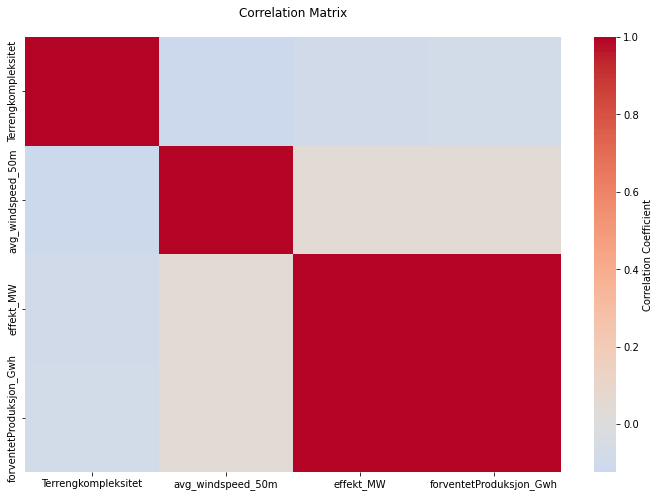

In [101]:
corrMatrix = vindkraft[cols].corr()
plt.figure(figsize=(12,8))
sn.heatmap(corrMatrix, annot=False,center=0,cmap='coolwarm',cbar_kws={'label':'Correlation Coefficient'})
plt.title('Correlation Matrix',pad=20)
plt.show()

### Construction Date

Number of Datapoints: 60


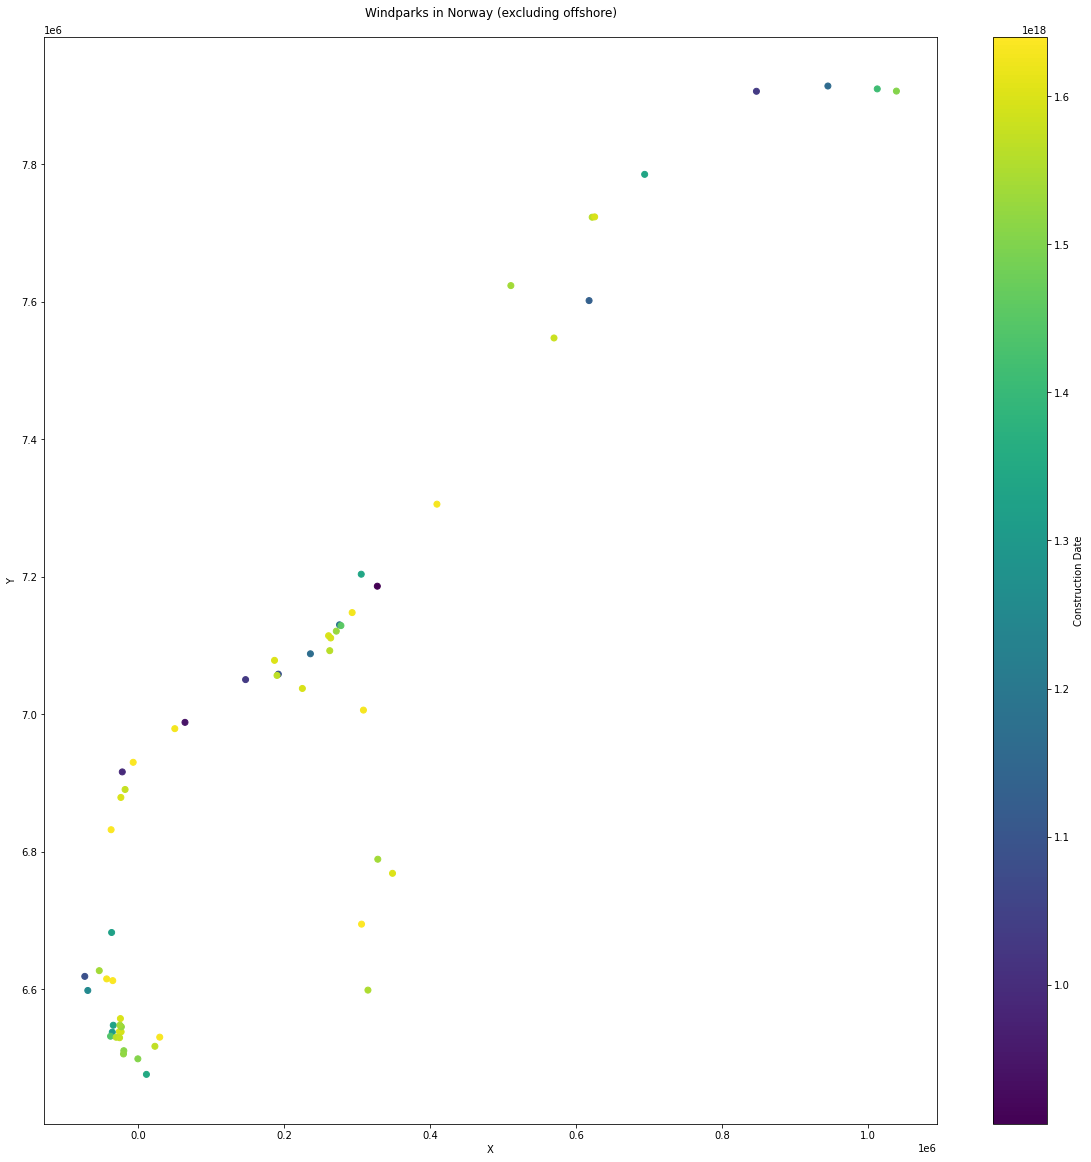

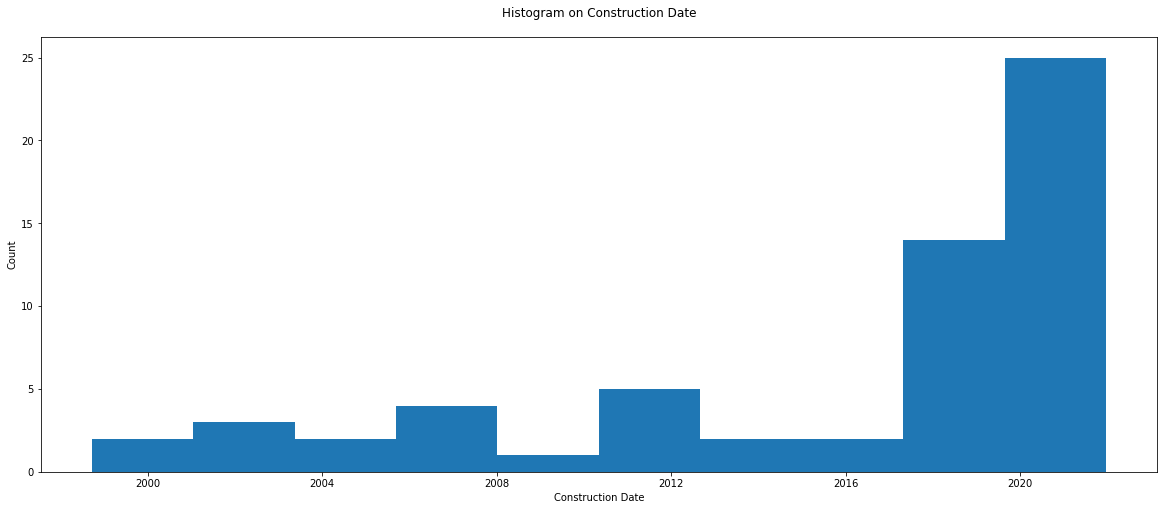

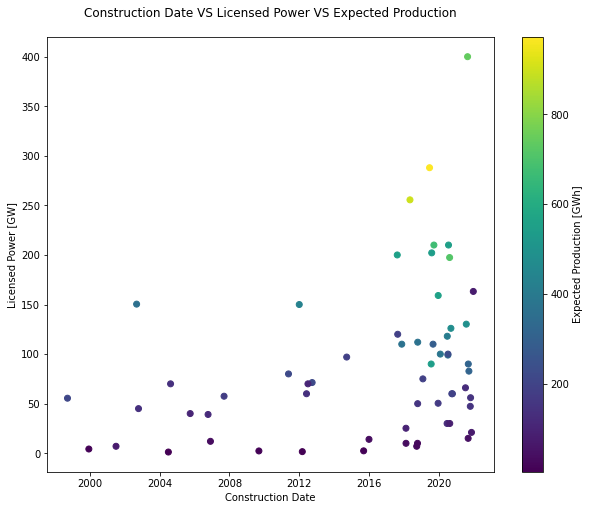

In [102]:
vindkraft.drop(vindkraft[vindkraft['idriftDato'].isna()].index,axis=0,inplace=True)
vindkraft.set_index(np.arange(0,len(vindkraft)),inplace=True)
print('Number of Datapoints:', len(vindkraft))

plt.figure(figsize=(20,20))
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['idriftDato'])
plt.colorbar(label='Construction Date')
plt.title('Windparks in Norway (excluding offshore)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure(figsize = (20,8))
plt.hist(vindkraft['idriftDato'])
plt.title('Histogram on Construction Date',pad=20)
plt.xlabel('Construction Date')
plt.ylabel('Count')
plt.show()

plt.figure(figsize = (10,8))
plt.scatter(vindkraft['idriftDato'],vindkraft['effekt_MW'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected Production [GWh]')
plt.xlabel('Construction Date')
plt.ylabel('Licensed Power [GW]')
plt.title('Construction Date VS Licensed Power VS Expected Production', pad=20)
plt.show()

## Spatial Modelling

### Re-Import Windfarm Data

In [103]:
vindkraft = pd.read_excel('./data/vindkraft.xlsx',usecols=['forventetProduksjon_Gwh','X','Y'])
vindkraft.drop(vindkraft[vindkraft['forventetProduksjon_Gwh'].isna()].index,axis=0,inplace=True)
vindkraft.drop(vindkraft[vindkraft['forventetProduksjon_Gwh']>=3000].index,axis=0,inplace=True) #only onshore
vindkraft.set_index(np.arange(0,len(vindkraft)),inplace=True)
print('Number of Datapoints:', len(vindkraft))
vindkraft.head()

Number of Datapoints: 257


forventetProduksjon_Gwh            X             Y
0                     8.16  -40480.2803  6.527760e+06
1                   510.00  -24464.1658  6.534317e+06
2                  1190.00   58219.5512  6.995506e+06
3                   485.29  293077.7321  7.147981e+06
4                   544.00  541877.4412  7.677462e+06

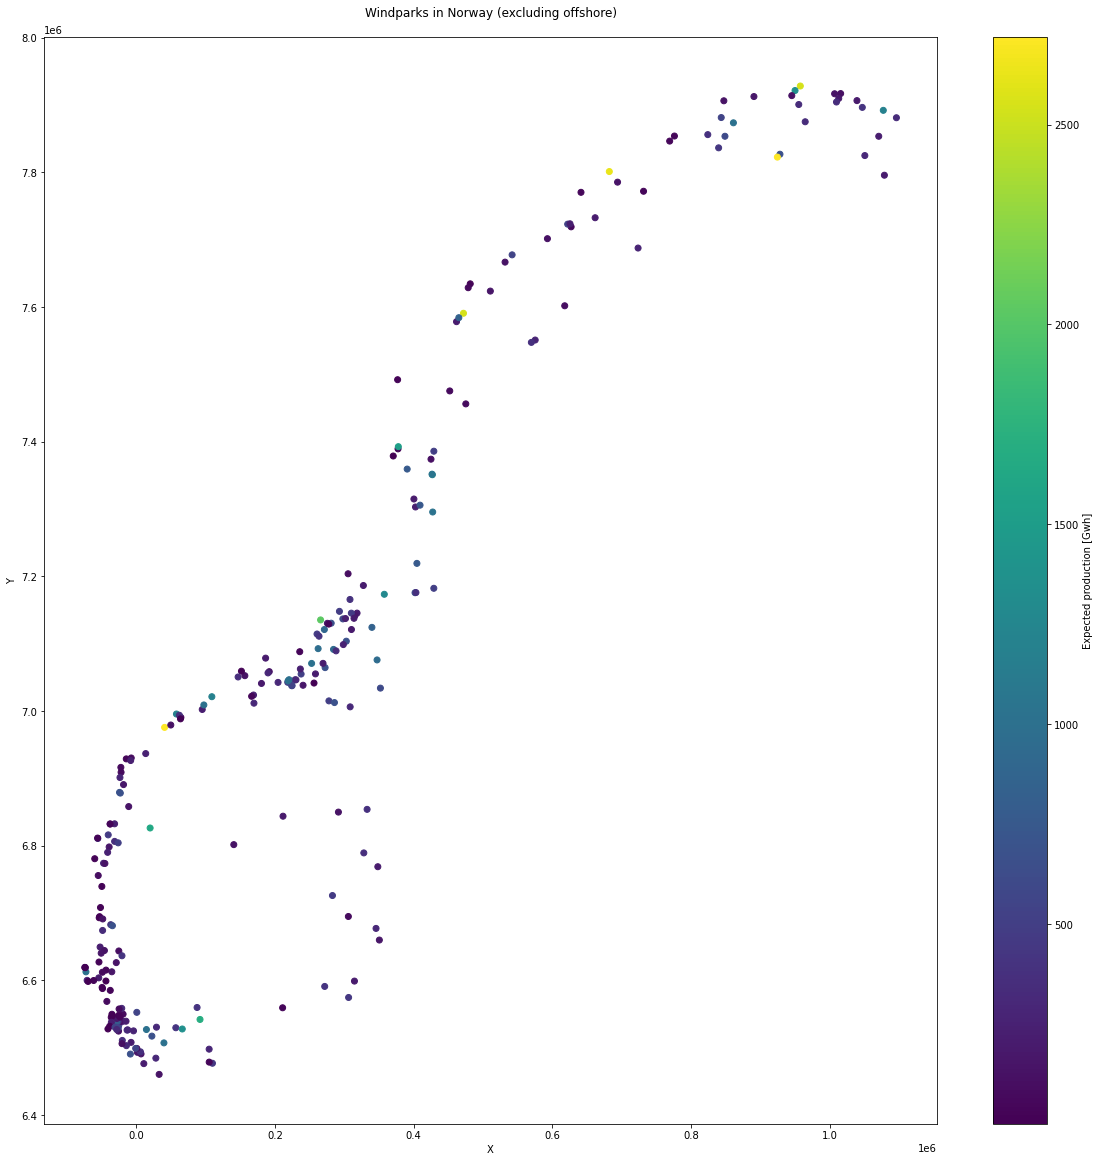

In [104]:
plt.figure(figsize=(20,20))

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')

plt.title('Windparks in Norway (excluding offshore)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

### Select South-Western Region

In [105]:
vindkraft.drop(vindkraft[vindkraft['X']>=0.4e6].index,axis=0,inplace=True)
vindkraft.drop(vindkraft[vindkraft['Y']>=7.2e6].index,axis=0,inplace=True)
vindkraft.set_index(np.arange(0,len(vindkraft)),inplace=True)
print('Number of Datapoints:', len(vindkraft))
vindkraft.head()

Number of Datapoints: 189


forventetProduksjon_Gwh            X             Y
0                     8.16  -40480.2803  6.527760e+06
1                   510.00  -24464.1658  6.534317e+06
2                  1190.00   58219.5512  6.995506e+06
3                   485.29  293077.7321  7.147981e+06
4                   149.93  -34912.2300  6.612662e+06

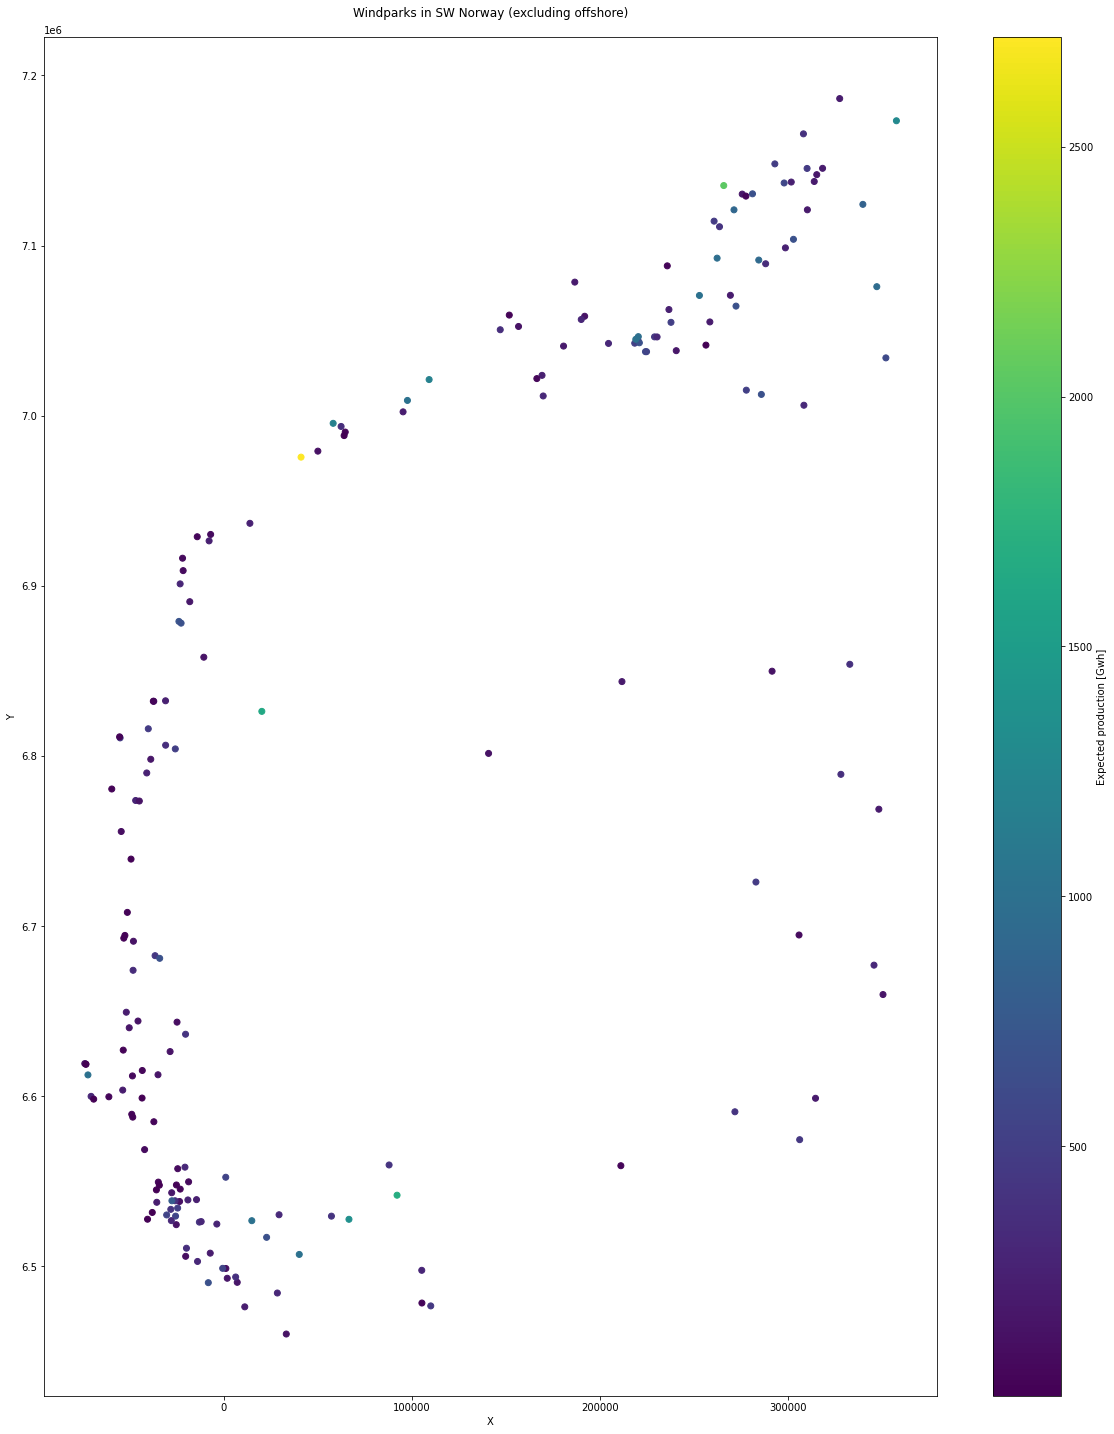

In [106]:
plt.figure(figsize=(20,25))


plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])

plt.colorbar(label='Expected production [Gwh]')

plt.title('Windparks in SW Norway (excluding offshore)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()



### Calculate Distances and Angles Between Datapoints

In [107]:
for i in range(len(vindkraft)):
    vindkraft['X_dist_from_'+str(i)] = vindkraft['X']-vindkraft['X'][i]
    vindkraft['Y_dist_from_'+str(i)] = vindkraft['Y']-vindkraft['Y'][i]
    vindkraft['dist_from_'+str(i)] = np.sqrt(np.square(vindkraft['X']-vindkraft['X'][i])+np.square(vindkraft['Y']-vindkraft['Y'][i]))
    vindkraft['angle_°_to_'+str(i)] = np.rad2deg(np.arctan(vindkraft['X_dist_from_'+str(i)]/vindkraft['Y_dist_from_'+str(i)]))
    vindkraft['heading_°_to_'+str(i)] = np.where(-vindkraft['Y_dist_from_'+str(i)]<0,180+vindkraft['angle_°_to_'+str(i)],np.where(-vindkraft['X_dist_from_'+str(i)]<0,360+vindkraft['angle_°_to_'+str(i)],vindkraft['angle_°_to_'+str(i)]))

vindkraft = vindkraft.copy() #to de-fragment the dataframe
vindkraft.head()

forventetProduksjon_Gwh            X             Y  X_dist_from_0  \
0                     8.16  -40480.2803  6.527760e+06         0.0000   
1                   510.00  -24464.1658  6.534317e+06     16016.1145   
2                  1190.00   58219.5512  6.995506e+06     98699.8315   
3                   485.29  293077.7321  7.147981e+06    333558.0124   
4                   149.93  -34912.2300  6.612662e+06      5568.0503   

   Y_dist_from_0    dist_from_0  angle_°_to_0  heading_°_to_0  X_dist_from_1  \
0         0.0000       0.000000           NaN             NaN    -16016.1145   
1      6556.9602   17306.347123     67.735921      247.735921         0.0000   
2    467746.2115  478046.206042     11.915275      191.915275     82683.7170   
3    620221.8017  704227.258021     28.271559      208.271559    317541.8979   
4     84902.2760   85084.661685      3.752191      183.752191    -10448.0642   

   Y_dist_from_1  ...  X_dist_from_187  Y_dist_from_187  dist_from_187  \
0     -6556.9602  ...     -276367.7359     -560294.9170  624747.564591   
1         0.0000  ...     -260351.6214     -553737.9568  611889.443908   
2    461189.2513  ...     -177667.9044      -92548.7055  200327.599555   
3    613664.8415  ...       57190.2765       59926.8847   82836.943666   
4     78345.3158  ...     -270799.6856     -475392.6410  547111.170456   

   angle_°_to_187  heading_°_to_187  X_dist_from_188  Y_dist_from_188  \
0       26.255006         26.255006        2905.5200      -71213.6383   
1       25.181557         25.181557       18921.6345      -64656.6781   
2       62.484614         62.484614      101605.3515      396532.5732   
3       43.661447        223.661447      336463.5324      549008.1634   
4       29.667298         29.667298        8473.5703       13688.6377   

   dist_from_188  angle_°_to_188  heading_°_to_188  
0   71272.886334       -2.336375        357.663625  
1   67368.496162      -16.311999        343.688001  
2  409343.045699       14.371949        194.371949  
3  643908.123970       31.502344        211.502344  
4   16099.074374       31.758426        211.758426  

[5 rows x 948 columns]

In [108]:
mean_angle = 0
std_angle = 0
mean_dist = 0
for i in range(len(vindkraft)):
    mean_angle += np.mean(vindkraft['angle_°_to_'+str(i)])
    std_angle += np.std(vindkraft['angle_°_to_'+str(i)])
    mean_dist += np.mean(vindkraft['dist_from_'+str(i)])
mean_angle = mean_angle/len(vindkraft)
std_angle = std_angle/len(vindkraft)
mean_dist = mean_dist/len(vindkraft)
print(mean_angle,std_angle,mean_dist)

15.100145428727906 35.08604895761831 326301.8893799162


### De-Clustering

#### Define De-Clustering Grid and Find corresponding Gridcell for each Datapoint

In [109]:
DC_nx = 10
DC_ny = 10
DC_origin_x = vindkraft['X'].min()-1
DC_origin_y = vindkraft['Y'].min()-1
DC_X_array = np.linspace(DC_origin_x,vindkraft['X'].max(),DC_nx)
DC_Y_array = np.linspace(DC_origin_y,vindkraft['Y'].max(),DC_ny)

DC_X_ind = np.zeros(len(vindkraft))
DC_Y_ind = np.zeros(len(vindkraft))

vindkraft['DC_Cell_ind'] = np.zeros(len(vindkraft))

for i in range(len(vindkraft)):
    DC_X_ind[i] = np.where(vindkraft['X'][i]<=DC_X_array)[0][0]
    DC_Y_ind[i] = np.where(vindkraft['Y'][i]<=DC_Y_array)[0][0]
    vindkraft['DC_Cell_ind'][i] = DC_nx*DC_Y_ind[i]+DC_X_ind[i]
vindkraft.head()

forventetProduksjon_Gwh            X             Y  X_dist_from_0  \
0                     8.16  -40480.2803  6.527760e+06         0.0000   
1                   510.00  -24464.1658  6.534317e+06     16016.1145   
2                  1190.00   58219.5512  6.995506e+06     98699.8315   
3                   485.29  293077.7321  7.147981e+06    333558.0124   
4                   149.93  -34912.2300  6.612662e+06      5568.0503   

   Y_dist_from_0    dist_from_0  angle_°_to_0  heading_°_to_0  X_dist_from_1  \
0         0.0000       0.000000           NaN             NaN    -16016.1145   
1      6556.9602   17306.347123     67.735921      247.735921         0.0000   
2    467746.2115  478046.206042     11.915275      191.915275     82683.7170   
3    620221.8017  704227.258021     28.271559      208.271559    317541.8979   
4     84902.2760   85084.661685      3.752191      183.752191    -10448.0642   

   Y_dist_from_1  ...  Y_dist_from_187  dist_from_187  angle_°_to_187  \
0     -6556.9602  ...     -560294.9170  624747.564591       26.255006   
1         0.0000  ...     -553737.9568  611889.443908       25.181557   
2    461189.2513  ...      -92548.7055  200327.599555       62.484614   
3    613664.8415  ...       59926.8847   82836.943666       43.661447   
4     78345.3158  ...     -475392.6410  547111.170456       29.667298   

   heading_°_to_187  X_dist_from_188  Y_dist_from_188  dist_from_188  \
0         26.255006        2905.5200      -71213.6383   71272.886334   
1         25.181557       18921.6345      -64656.6781   67368.496162   
2         62.484614      101605.3515      396532.5732  409343.045699   
3        223.661447      336463.5324      549008.1634  643908.123970   
4         29.667298        8473.5703       13688.6377   16099.074374   

   angle_°_to_188  heading_°_to_188  DC_Cell_ind  
0       -2.336375        357.663625         11.0  
1      -16.311999        343.688001         12.0  
2       14.371949        194.371949         73.0  
3       31.502344        211.502344         98.0  
4       31.758426        211.758426         21.0  

[5 rows x 949 columns]

#### Visualize De-Clustering Grid

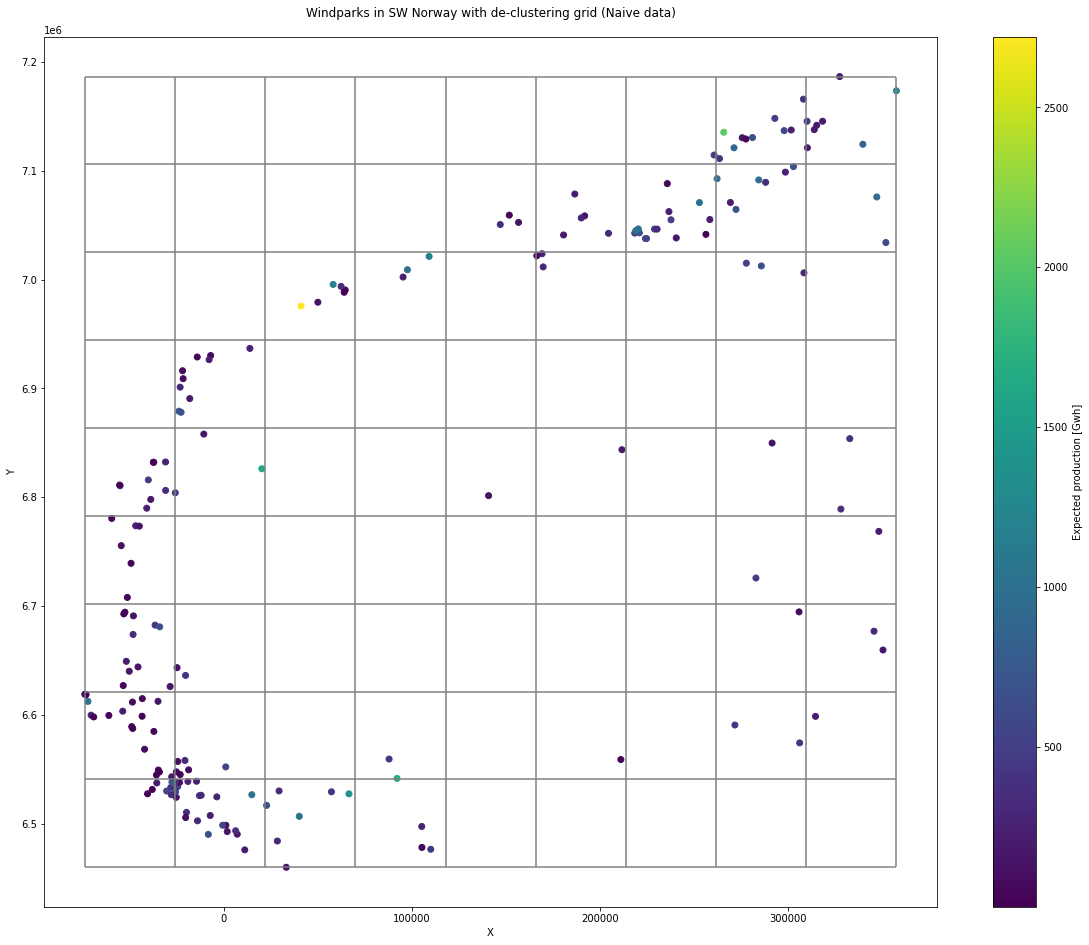

In [110]:
plt.figure(figsize=(20,16))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'])
plt.colorbar(label='Expected production [Gwh]')
plt.title('Windparks in SW Norway with de-clustering grid (Naive data)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



#### Calculate Number of Datapoints per Cell and Number of occupied Cells

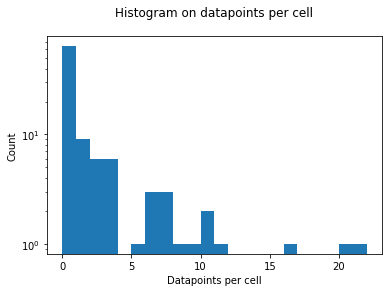

Number of occupied cells: 36


In [111]:
Num_data_in_cell = np.zeros(DC_nx*DC_ny)
for i in range(DC_nx*DC_ny):
    Num_data_in_cell[i] = len(np.where(vindkraft['DC_Cell_ind']==i)[0])

plt.hist(Num_data_in_cell,bins=int(np.max(Num_data_in_cell)))
plt.yscale('log')
plt.xlabel('Datapoints per cell')
plt.ylabel('Count')
plt.title('Histogram on datapoints per cell',pad=20)
plt.show()

n_occ = len(np.where(Num_data_in_cell>0)[0])
print('Number of occupied cells:' ,n_occ)

#### Calculate Cell Weights and apply to Datapoints

In [112]:
Cell_weight = 1/Num_data_in_cell*len(vindkraft)/n_occ

vindkraft['Weight'] = np.zeros(len(vindkraft))
for i in range(len(vindkraft)):
    vindkraft['Weight'][i] = Cell_weight[int(vindkraft['DC_Cell_ind'][i])]
vindkraft.head()

forventetProduksjon_Gwh            X             Y  X_dist_from_0  \
0                     8.16  -40480.2803  6.527760e+06         0.0000   
1                   510.00  -24464.1658  6.534317e+06     16016.1145   
2                  1190.00   58219.5512  6.995506e+06     98699.8315   
3                   485.29  293077.7321  7.147981e+06    333558.0124   
4                   149.93  -34912.2300  6.612662e+06      5568.0503   

   Y_dist_from_0    dist_from_0  angle_°_to_0  heading_°_to_0  X_dist_from_1  \
0         0.0000       0.000000           NaN             NaN    -16016.1145   
1      6556.9602   17306.347123     67.735921      247.735921         0.0000   
2    467746.2115  478046.206042     11.915275      191.915275     82683.7170   
3    620221.8017  704227.258021     28.271559      208.271559    317541.8979   
4     84902.2760   85084.661685      3.752191      183.752191    -10448.0642   

   Y_dist_from_1  ...  dist_from_187  angle_°_to_187  heading_°_to_187  \
0     -6556.9602  ...  624747.564591       26.255006         26.255006   
1         0.0000  ...  611889.443908       25.181557         25.181557   
2    461189.2513  ...  200327.599555       62.484614         62.484614   
3    613664.8415  ...   82836.943666       43.661447        223.661447   
4     78345.3158  ...  547111.170456       29.667298         29.667298   

   X_dist_from_188  Y_dist_from_188  dist_from_188  angle_°_to_188  \
0        2905.5200      -71213.6383   71272.886334       -2.336375   
1       18921.6345      -64656.6781   67368.496162      -16.311999   
2      101605.3515      396532.5732  409343.045699       14.371949   
3      336463.5324      549008.1634  643908.123970       31.502344   
4        8473.5703       13688.6377   16099.074374       31.758426   

   heading_°_to_188  DC_Cell_ind    Weight  
0        357.663625         11.0  0.750000  
1        343.688001         12.0  0.238636  
2        194.371949         73.0  0.875000  
3        211.502344         98.0  0.525000  
4        211.758426         21.0  0.262500  

[5 rows x 950 columns]

In [113]:
vindkraft['weighted'] =vindkraft['Weight']*vindkraft['forventetProduksjon_Gwh']
vindkraft.head()

forventetProduksjon_Gwh            X             Y  X_dist_from_0  \
0                     8.16  -40480.2803  6.527760e+06         0.0000   
1                   510.00  -24464.1658  6.534317e+06     16016.1145   
2                  1190.00   58219.5512  6.995506e+06     98699.8315   
3                   485.29  293077.7321  7.147981e+06    333558.0124   
4                   149.93  -34912.2300  6.612662e+06      5568.0503   

   Y_dist_from_0    dist_from_0  angle_°_to_0  heading_°_to_0  X_dist_from_1  \
0         0.0000       0.000000           NaN             NaN    -16016.1145   
1      6556.9602   17306.347123     67.735921      247.735921         0.0000   
2    467746.2115  478046.206042     11.915275      191.915275     82683.7170   
3    620221.8017  704227.258021     28.271559      208.271559    317541.8979   
4     84902.2760   85084.661685      3.752191      183.752191    -10448.0642   

   Y_dist_from_1  ...  angle_°_to_187  heading_°_to_187  X_dist_from_188  \
0     -6556.9602  ...       26.255006         26.255006        2905.5200   
1         0.0000  ...       25.181557         25.181557       18921.6345   
2    461189.2513  ...       62.484614         62.484614      101605.3515   
3    613664.8415  ...       43.661447        223.661447      336463.5324   
4     78345.3158  ...       29.667298         29.667298        8473.5703   

   Y_dist_from_188  dist_from_188  angle_°_to_188  heading_°_to_188  \
0      -71213.6383   71272.886334       -2.336375        357.663625   
1      -64656.6781   67368.496162      -16.311999        343.688001   
2      396532.5732  409343.045699       14.371949        194.371949   
3      549008.1634  643908.123970       31.502344        211.502344   
4       13688.6377   16099.074374       31.758426        211.758426   

   DC_Cell_ind    Weight     weighted  
0         11.0  0.750000     6.120000  
1         12.0  0.238636   121.704545  
2         73.0  0.875000  1041.250000  
3         98.0  0.525000   254.777250  
4         21.0  0.262500    39.356625  

[5 rows x 951 columns]

#### Histograms on Naive- & Weighted Data and Weights

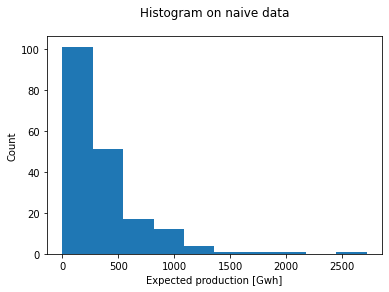

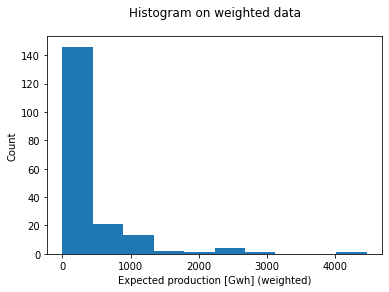

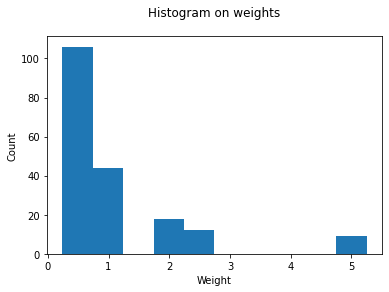

In [114]:
plt.hist(vindkraft['forventetProduksjon_Gwh'])
plt.xlabel('Expected production [Gwh]')
plt.ylabel('Count')
plt.title('Histogram on naive data',pad=20)
plt.show()

plt.hist(vindkraft['weighted'])
plt.xlabel('Expected production [Gwh] (weighted)')
plt.ylabel('Count')
plt.title('Histogram on weighted data',pad=20)
plt.show()

plt.hist(vindkraft['Weight'])
plt.xlabel('Weight')
plt.ylabel('Count')
plt.title('Histogram on weights',pad=20)
plt.show()

#### Visualize Weights and Weighted Data

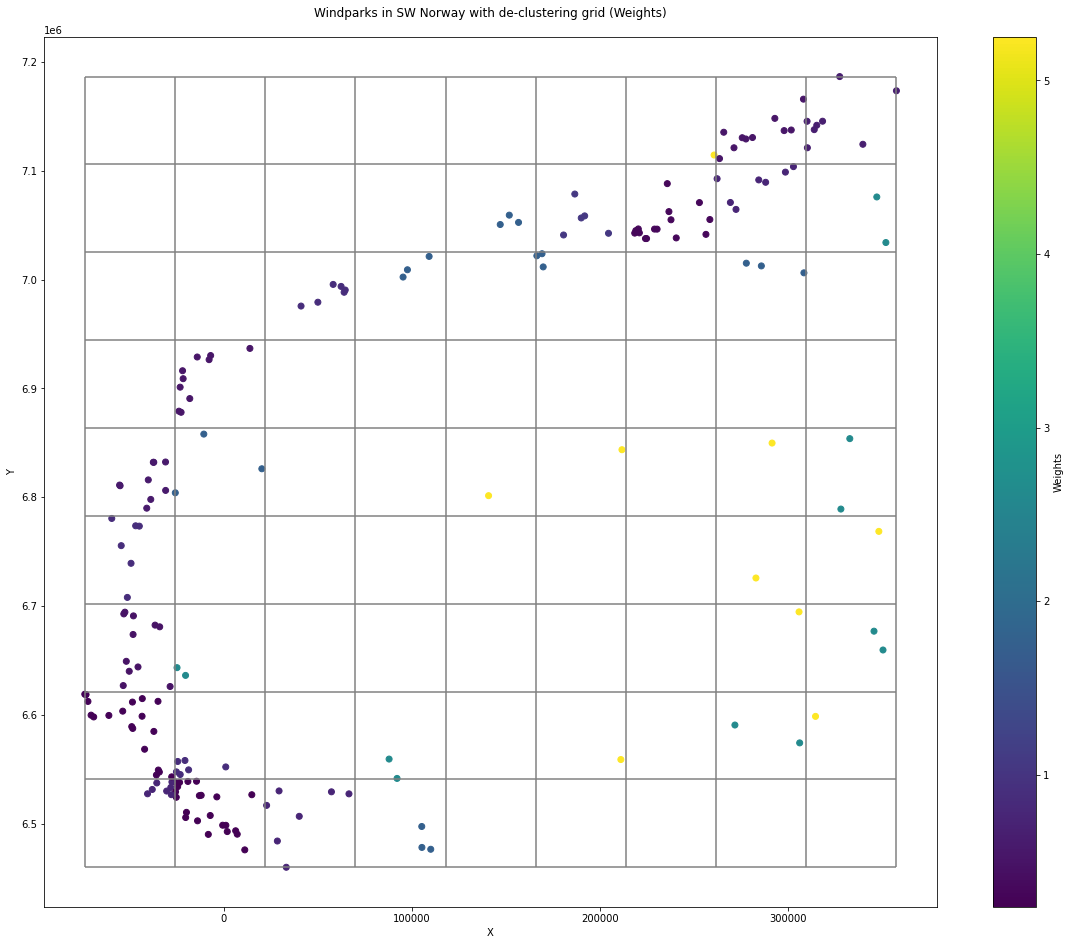

In [115]:
plt.figure(figsize=(20,16))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['Weight'])
plt.colorbar(label='Weights')
plt.title('Windparks in SW Norway with de-clustering grid (Weights)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



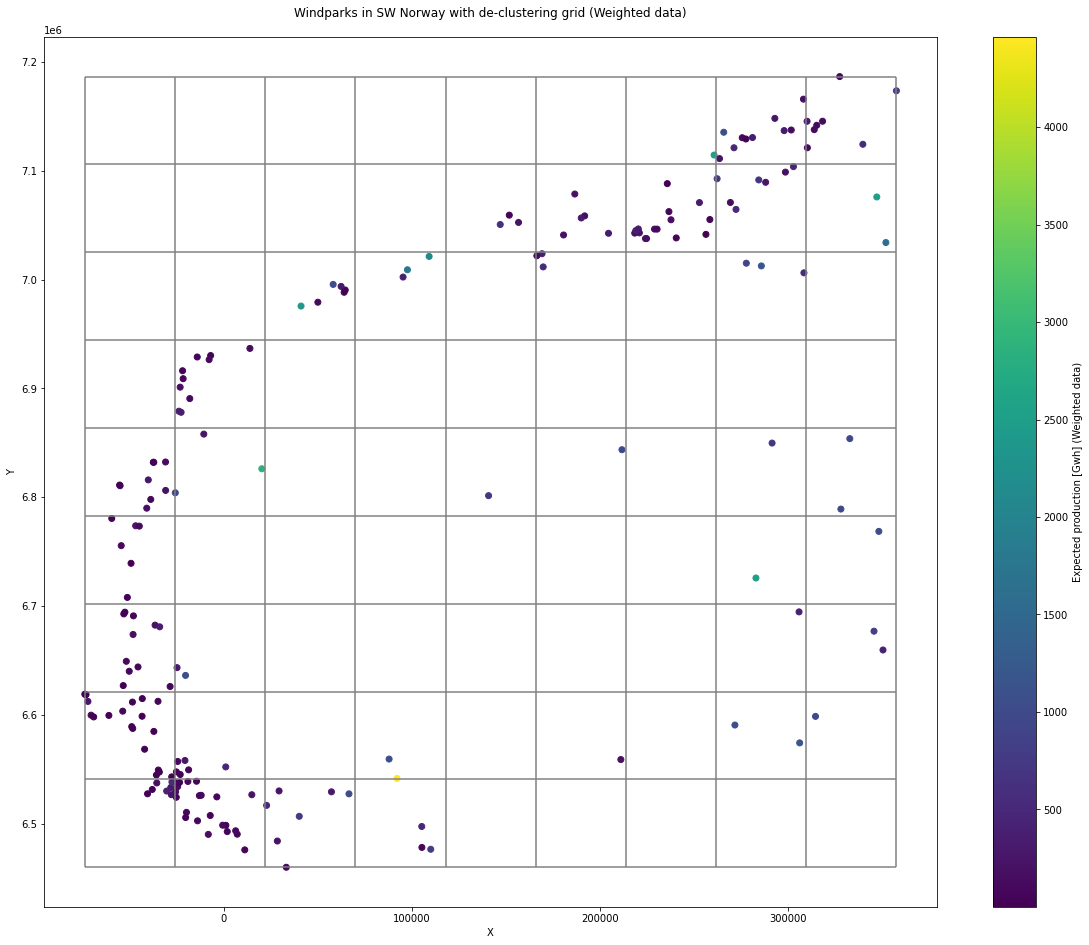

In [116]:
plt.figure(figsize=(20,16))

plt.hlines(DC_Y_array,xmin=DC_origin_x,xmax=np.max(vindkraft['X']),color='grey')
plt.vlines(DC_X_array,ymin=DC_origin_y,ymax=np.max(vindkraft['Y']),color='grey')
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['weighted'])
plt.colorbar(label='Expected production [Gwh] (Weighted data)')
plt.title('Windparks in SW Norway with de-clustering grid (Weighted data)',pad=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



### Experimental Semi-Variogram

#### Define Functions

In [117]:
def SV_check_in_lag(Origin_X,Origin_Y,X,Y,distance,heading,dir_vect,angl_tol,bandwidth,lag_dist,lag_tol,lag_num):
    lag_upper_lim = lag_num*lag_dist+lag_tol
    lag_lower_lim = lag_num*lag_dist-lag_tol
    angle_upper_lim = dir_vect+angl_tol
    angle_lower_lim = dir_vect-angl_tol
    if heading+180 >360:
        heading -=180
    else:
        heading+=180

    dist_from_dir_vect = np.abs(np.cos(np.deg2rad(-1*(dir_vect+90)))*(Origin_Y-Y)-np.sin((np.deg2rad(-1*(dir_vect+90))))*(Origin_X-X))

    if lag_lower_lim < distance < lag_upper_lim :
        if angle_lower_lim < heading < angle_upper_lim:
            if dist_from_dir_vect < bandwidth:
                return True
            else:
                return False
        else:
            return False
    else:
        return False

In [118]:
def gamma(origin_value,node_values):
    correlation = np.square(origin_value-node_values)
    return 0.5*np.sum(correlation)/len(node_values)

#### Parameters for Experimental Semi-Variogram

In [119]:
N = len(vindkraft)
dir_vect = 42
angl_tol = 18
bandwidth = 60000
lag_dist = 50000
lag_tol = 25000
n_lags = 12


#### Find Datapoints for each Lag-Origin Combination

In [120]:
point_in_lag = np.zeros((n_lags,N,N))
for lag_num in range(n_lags):
    for i in range(N):
        for j in range(N):
            point_in_lag[lag_num,i,j] = SV_check_in_lag(vindkraft['X'][i],vindkraft['Y'][i],vindkraft['X'][j],vindkraft['Y'][j],vindkraft['dist_from_'+str(i)][j],vindkraft['heading_°_to_'+str(i)][j],dir_vect=dir_vect,angl_tol=angl_tol,bandwidth=bandwidth,lag_dist=lag_dist,lag_tol=lag_tol,lag_num=lag_num)

#### Calculate semi-variance at each Lag-Origin Combination

In [121]:
relevant_points = {}
gamma_lag_num_i = np.zeros((n_lags,N))
for lag_num in range(n_lags):
    for i in range(N):
        relevant_points[lag_num,i] = np.where(point_in_lag[lag_num,i]==1)[0]

        gamma_lag_num_i[lag_num,i] = gamma(vindkraft['weighted'][i],np.array(vindkraft['weighted'][relevant_points[lag_num,i]].values))

#### Visualize and Analyze Experimental Semi-Variogram Parameters and Result

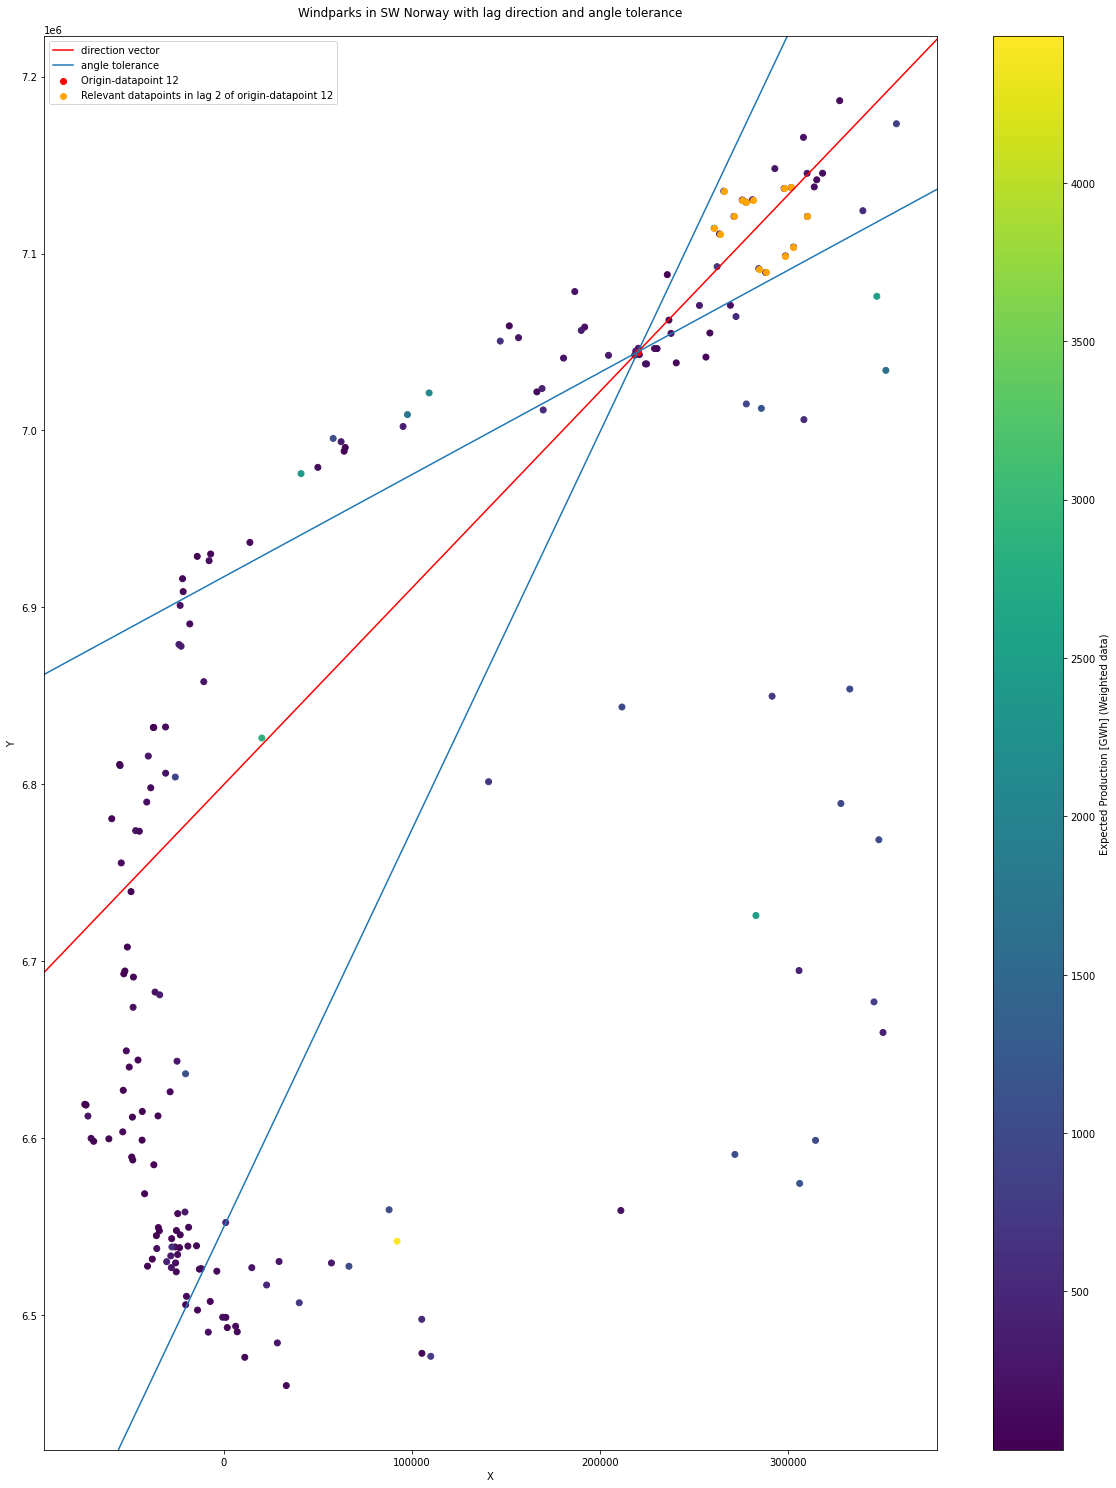

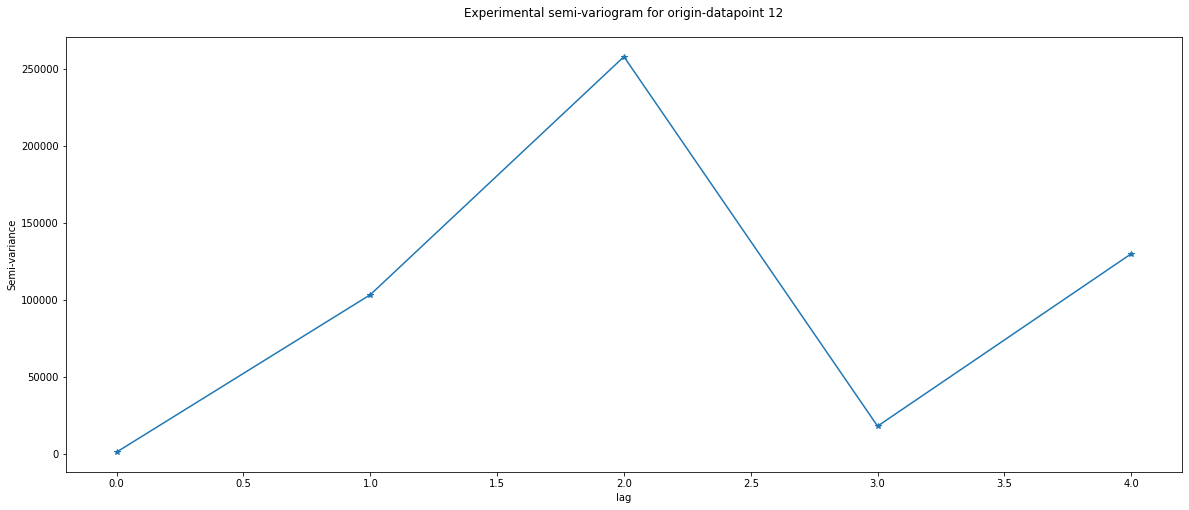

In [151]:
POI = 12 #choose datapoint of interest
LOI = 2 #choose lag of interest

plt.figure(figsize=(20,26))
plt.axline((vindkraft['X'][POI],vindkraft['Y'][POI]),slope=np.tan(np.deg2rad(-1*(dir_vect+90))),c='r',label='direction vector')
plt.axline((vindkraft['X'][POI],vindkraft['Y'][POI]),slope=np.tan(np.deg2rad(-1*(dir_vect-angl_tol+90))),label='angle tolerance')
plt.axline((vindkraft['X'][POI],vindkraft['Y'][POI]),slope=np.tan(np.deg2rad(-1*(dir_vect+angl_tol+90))))
plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['weighted'])
plt.colorbar(label='Expected Production [GWh] (Weighted data)')
plt.scatter(vindkraft['X'][POI],vindkraft['Y'][POI],c='r',label='Origin-datapoint '+str(POI))
plt.scatter(vindkraft['X'][relevant_points[LOI,POI]],vindkraft['Y'][relevant_points[LOI,POI]],c='orange',label='Relevant datapoints in lag '+str(LOI)+' of origin-datapoint '+str(POI))

plt.title('Windparks in SW Norway with lag direction and angle tolerance',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.legend()

plt.show()

plt.figure(figsize=(20,8))
plt.plot(gamma_lag_num_i[:,POI],'*-')
plt.title('Experimental semi-variogram for origin-datapoint '+str(POI),pad=20)
plt.xlabel('lag')
plt.ylabel('Semi-variance')
plt.show()


#### Calculate and Visualize Average Experimental Semi-Variogram across all datapoints

In [123]:
mean_gamma = np.zeros(n_lags)
for lag_num in range(n_lags):
    mean_gamma[lag_num] = np.mean(gamma_lag_num_i[lag_num][np.where(np.isnan(gamma_lag_num_i[lag_num])==False)])

mean_gamma = mean_gamma[~np.isnan(mean_gamma)]
n_lags = len(mean_gamma)


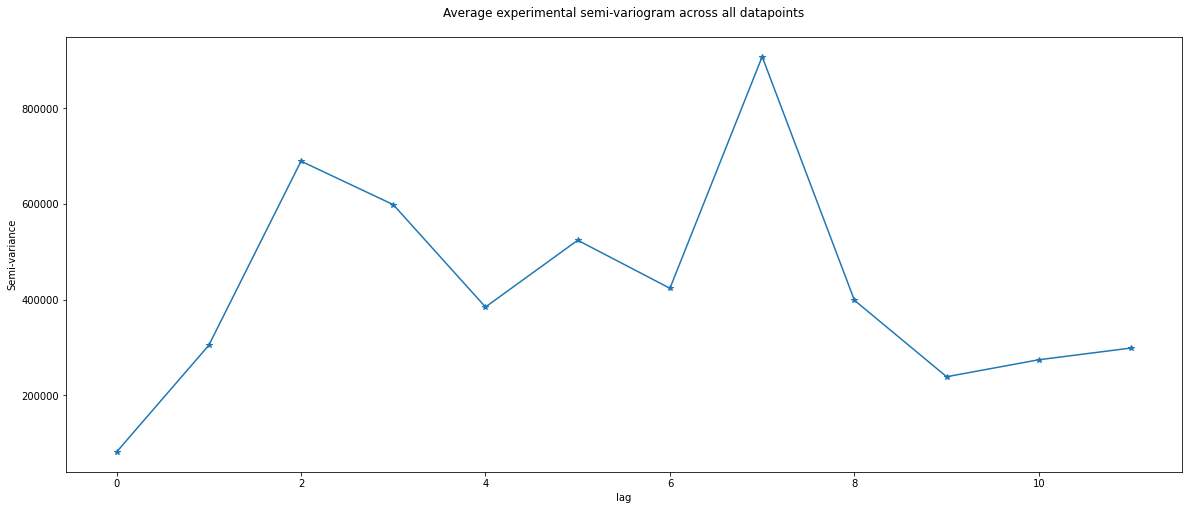

In [124]:

plt.figure(figsize=(20,8))
plt.plot(np.arange(n_lags),mean_gamma,'*-')
plt.title('Average experimental semi-variogram across all datapoints',pad=20)
plt.xlabel('lag')
plt.ylabel('Semi-variance')
plt.show()

### Fit Variogram Model

#### Define Variogram Models

In [125]:
def gauss_var(h,rang,sill,nugget):
    if nugget<0:  #Constraint to non-negative
        nugget = 0
    gamma = nugget + sill*(1-np.exp(-3*np.power(h/rang,2)))
    return gamma

In [126]:
def exp_var(h,rang,sill,nugget):
    if nugget<0:  #Constraint to non-negative
        nugget = 0
    gamma = nugget + sill*(1-np.exp(-3*h/rang))
    return gamma

In [127]:
def sph_var(h,rang,sill,nugget):
    if nugget<0:  #Constraint to non-negative
        nugget = 0
    gamma = nugget + np.where(h<rang, sill*(1.5*(h/rang)-0.5*np.power((h/rang),3)),sill) 
    return gamma

#### Fit Variogram Model

In [128]:
data_var = np.var(vindkraft['weighted'])
print('Data variance:',data_var)
print('Minimum average variance across all datapoints:',np.min(mean_gamma))

Data variance: 345760.01308546116
Minimum average variance across all datapoints: 81366.10271724404


In [129]:
lags = np.arange(0,n_lags*lag_dist,lag_dist)
lags = lags[:len(mean_gamma)]
params,_ = so.curve_fit(exp_var, xdata=lags, ydata=mean_gamma, bounds=[[150000,300000,2000],[450000,600000,85000]], p0=[200000,400000,30000])

rang = params[0]
sill = params[1]
nugget = params[2]

gamma_h = exp_var(lags,rang,sill,nugget)

#### Visualize Variogram Model

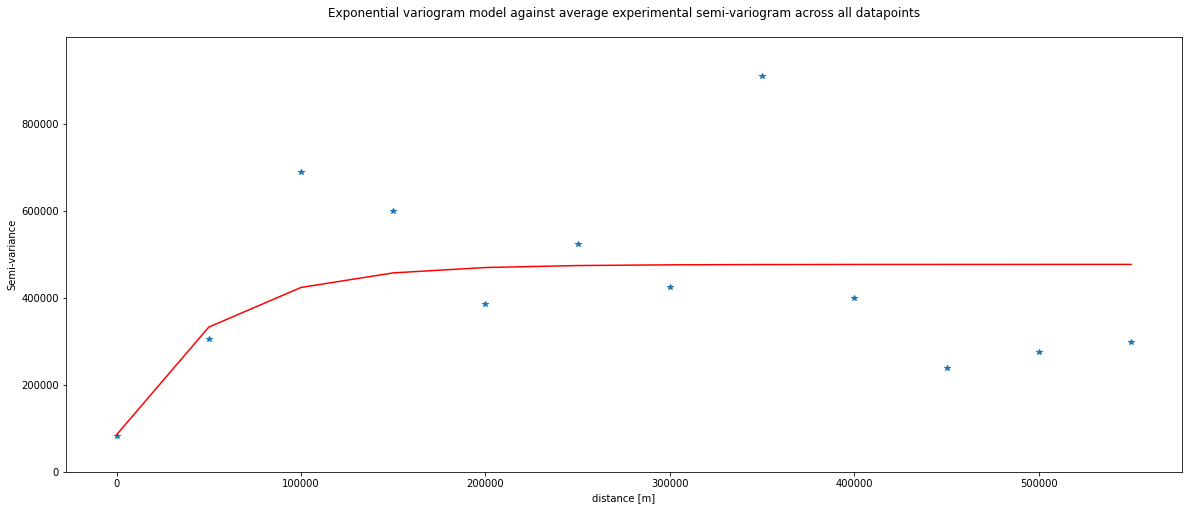

Exponential variogram
range = 150000.00000000003
sill = 391374.13492414705
nugget = 84999.99999999999


In [130]:
plt.figure(figsize=(20,8))

plt.plot(lags,mean_gamma,'*')
plt.plot(lags,gamma_h,'r')
plt.ylim([0,1.1*max(mean_gamma)])
plt.title('Exponential variogram model against average experimental semi-variogram across all datapoints',pad=20)
plt.xlabel('distance [m]')
plt.ylabel('Semi-variance')
plt.show()

print('Exponential variogram')
print('range =', rang)
print('sill =', sill)
print('nugget =', nugget)

### Kriging

#### Define Ordinary Krigging Function

In [131]:
def ordinary_krigging(dist,uo,rang,sill,nugget,values):
    gamma_i = exp_var(dist,rang,sill,nugget)
    gamma_o = exp_var(uo,rang,sill,nugget)
    Co = sill-(gamma_o-nugget)
    C=sill-(gamma_i-nugget)
    ones_vec = np.asmatrix(np.ones(len(values)))
    C_ok = np.r_[C,ones_vec] 
    col_vec = np.r_[ones_vec.T,np.asmatrix(0)]
    C_ok = np.c_[C_ok,col_vec]
    Co_ok = np.r_[Co,np.asmatrix(1)]
    lamb_ok = np.linalg.inv(C_ok)*Co_ok
    X_est_ok = lamb_ok[:-1].T*values
    sigma_ok = sill-lamb_ok[:-1].T*Co_ok[:-1]-lamb_ok[-1]
    return X_est_ok, sigma_ok
    

#### Get Data Values and -Coordinates and Calculate Distances

In [132]:
values = np.asmatrix(np.array(vindkraft['forventetProduksjon_Gwh'])).T

x_coord = np.array(vindkraft['X'])
y_coord = np.array(vindkraft['Y'])
dist = np.zeros((len(x_coord),len(y_coord)))

for i in range(len(x_coord)):
    dist[i] = np.sqrt(np.square(x_coord-x_coord[i])+np.square(y_coord-y_coord[i]))
dist = np.asmatrix(dist)


#### Define Kriging Grid, calculate Distance from each Gridpoint to each Datapoint and apply Ordinary Kriging

In [133]:
nx_low = min(vindkraft['X'])
nx_high = max(vindkraft['X'])
nx_num = 100
ny_low = min(vindkraft['Y'])
ny_high = max(vindkraft['Y'])
ny_num = nx_num

NX = np.linspace(nx_low,nx_high,nx_num)
NY = np.flip(np.linspace(ny_low,ny_high,ny_num))
u_x = np.zeros((len(NX),len(NY)))
u_y = np.zeros((len(NX),len(NY)))

X_est_ok = np.zeros((len(NX),len(NY)))
sigma_ok = np.zeros((len(NX),len(NY)))
for nx in range(len(NX)):
    for ny in range(len(NY)):
        sys.stdout.write('\r')
        sys.stdout.write(str((nx,ny))+'                                                                          ')
        sys.stdout.flush()
        u_x[nx,ny] = NX[nx]
        u_y[nx,ny] = NY[ny]
        uo = np.asmatrix(np.sqrt(np.square(x_coord-u_x[nx,ny])+np.square(y_coord-u_y[nx,ny]))).T
        X_est_ok[ny,nx] , sigma_ok[ny,nx] = ordinary_krigging(dist,uo,rang,sill,nugget,values)


(99, 99)                                                                          

#### Histogram on Kriging Estimates

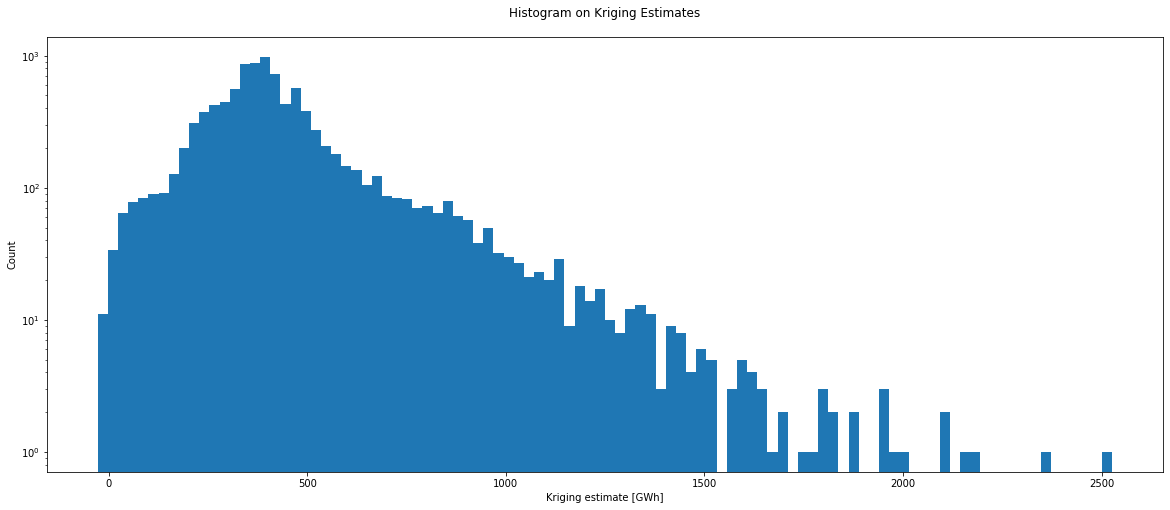

In [134]:
plt.figure(figsize=(20,8))
plt.hist(X_est_ok.flatten(),bins=100)
plt.yscale('log')
plt.xlabel('Kriging estimate [GWh]')
plt.ylabel('Count')
plt.title('Histogram on Kriging Estimates',pad=20)
plt.show()

#### Adjust Senseles Values below 0 to 0 and rescale to fit existing Data

In [135]:
X_est_ok_adjusted = np.where(X_est_ok<0,0,X_est_ok)
X_est_ok_adjusted = np.max(vindkraft['forventetProduksjon_Gwh'])*X_est_ok_adjusted/np.max(X_est_ok_adjusted)


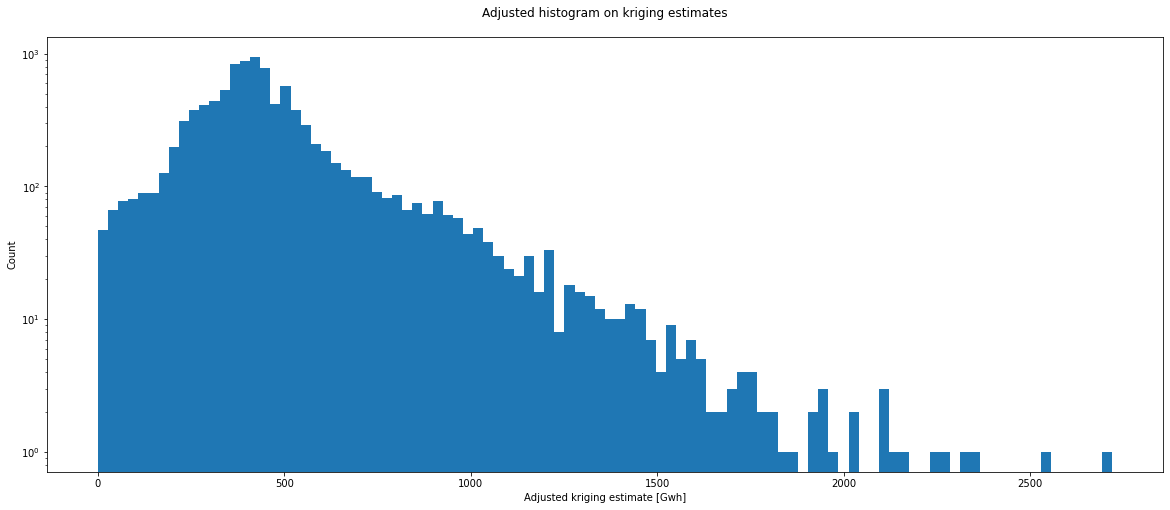

In [136]:
plt.figure(figsize=(20,8))

plt.hist(X_est_ok_adjusted.flatten(),bins=100)
plt.yscale('log')
plt.xlabel('Adjusted kriging estimate [Gwh]')
plt.ylabel('Count')
plt.title('Adjusted histogram on kriging estimates',pad=20)
plt.show()

#### Visualize Kriging Estemate with existing Datapoints over Terrain Complexity and Average Windspeed

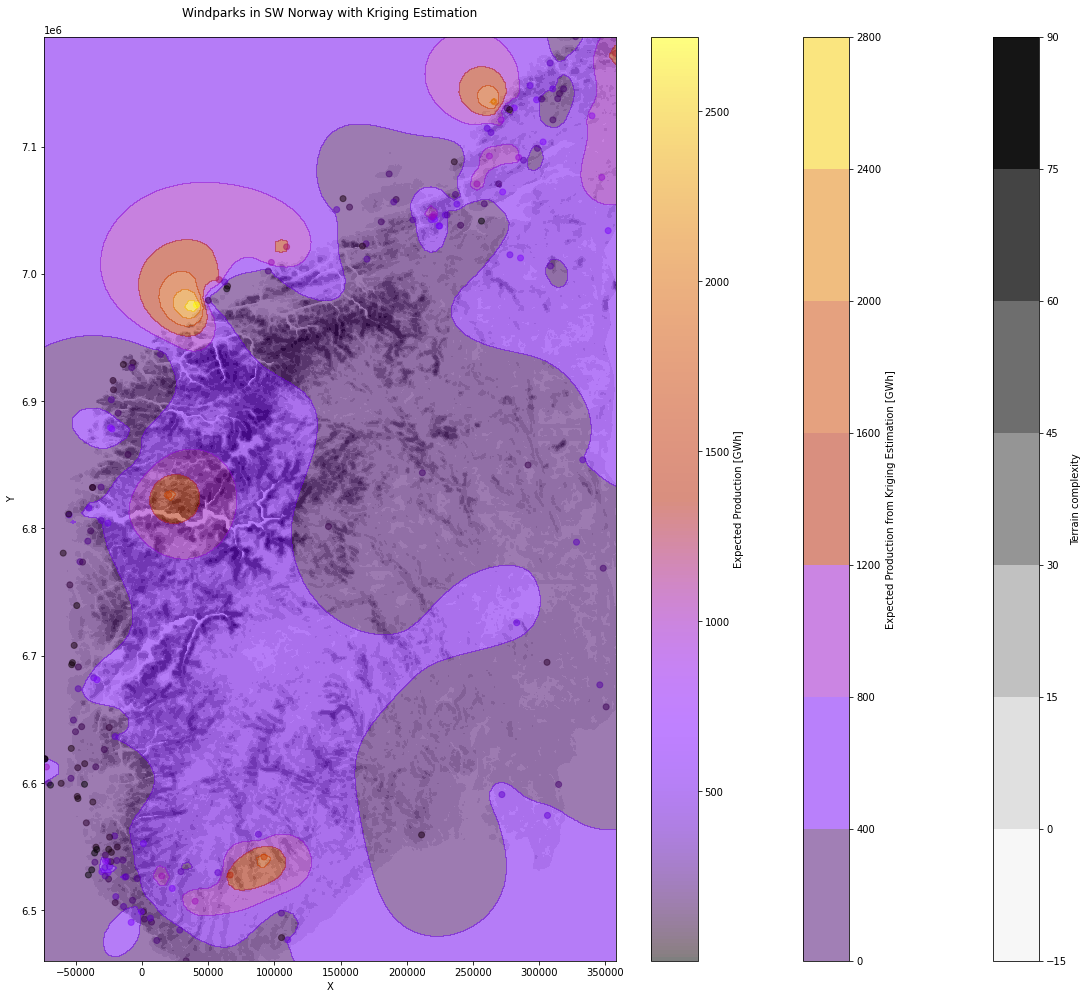

In [137]:
plt.figure(figsize=(20,17))

plt.contourf(Terrengkompleksitet.columns,Terrengkompleksitet.index, np.array(Terrengkompleksitet),alpha=1,cmap='Greys')
plt.colorbar(label='Terrain complexity')

plt.contourf(NX,NY,X_est_ok_adjusted,alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Expected Production from Kriging Estimation [GWh]')

plt.xlim(nx_low,nx_high)
plt.ylim(ny_low,ny_high)

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'],alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Expected Production [GWh]')

plt.title('Windparks in SW Norway with Kriging Estimation',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

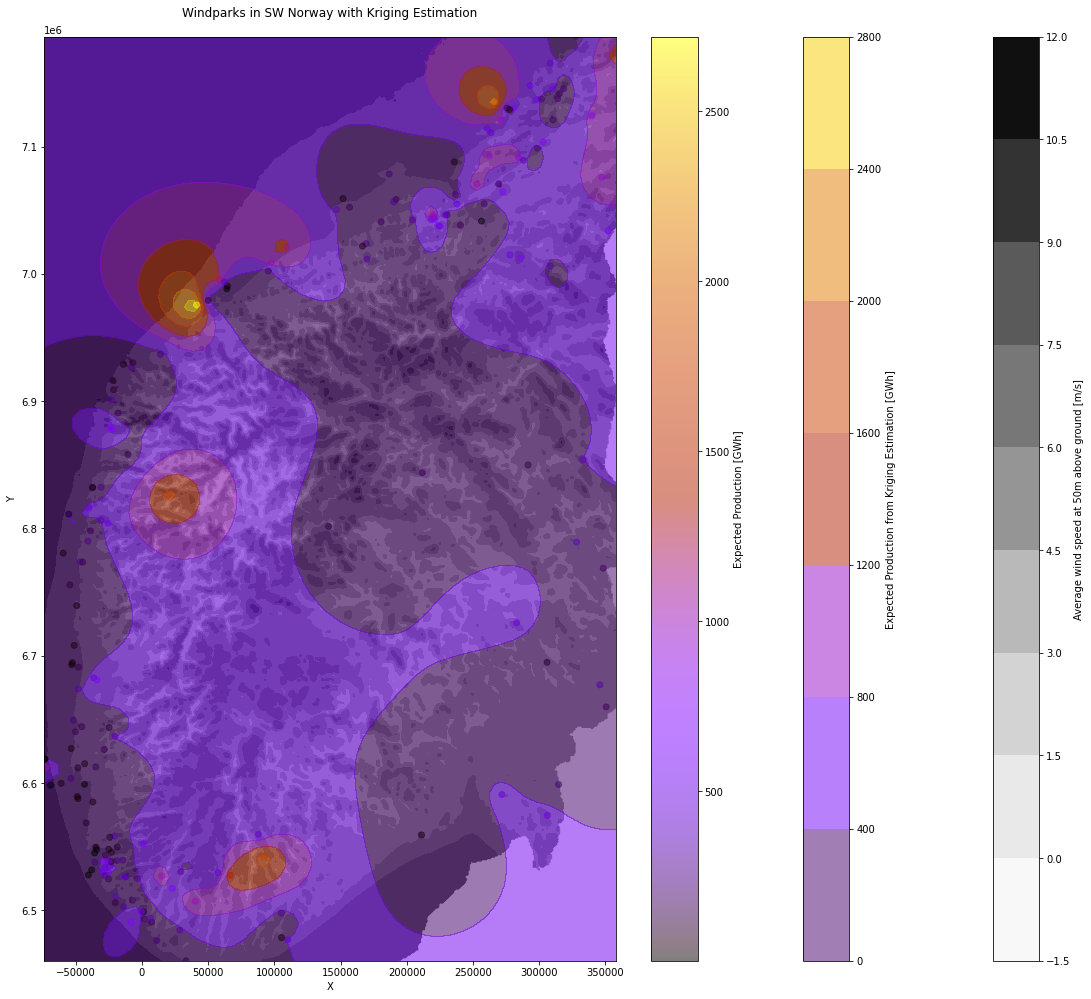

In [138]:
plt.figure(figsize=(20,17))

plt.contourf(avg_wind_50m.columns,avg_wind_50m.index, np.array(avg_wind_50m),alpha=1,cmap='Greys')
plt.colorbar(label='Average wind speed at 50m above ground [m/s]')

plt.contourf(NX,NY,X_est_ok_adjusted,alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Expected Production from Kriging Estimation [GWh]')

plt.xlim(nx_low,nx_high)
plt.ylim(ny_low,ny_high)

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'],alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Expected Production [GWh]')

plt.title('Windparks in SW Norway with Kriging Estimation',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

#### Visualize Kriging Error

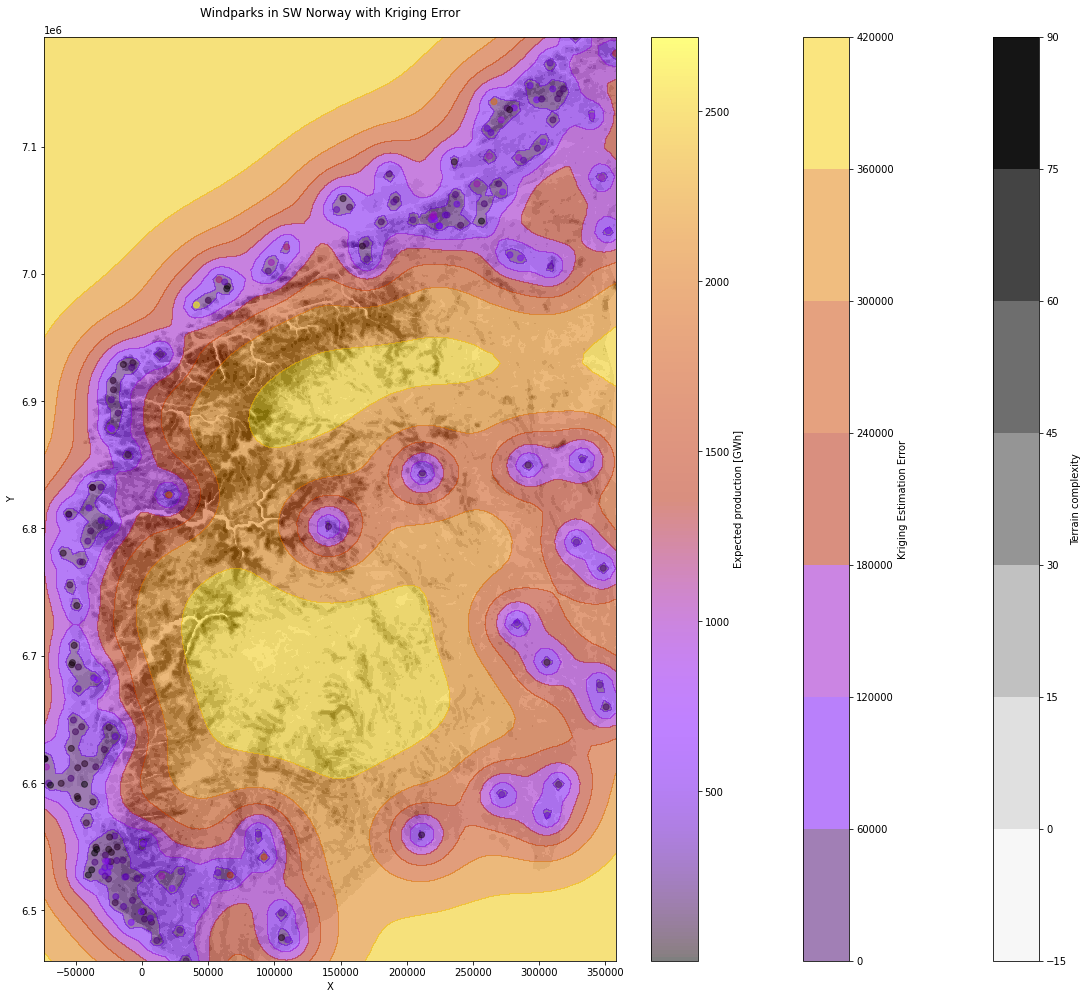

In [139]:
plt.figure(figsize=(20,17))

plt.contourf(Terrengkompleksitet.columns,Terrengkompleksitet.index, np.array(Terrengkompleksitet),alpha=1,cmap='Greys')
plt.colorbar(label='Terrain complexity')

plt.contourf(NX,NY,sigma_ok,alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Kriging Estimation Error')

plt.xlim(nx_low,nx_high)
plt.ylim(ny_low,ny_high)

plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'],alpha=0.5,cmap='gnuplot')
plt.colorbar(label='Expected production [GWh]')

plt.title('Windparks in SW Norway with Kriging Error',pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

### Data Analysis on Results

#### Sample Average Windspeed at Kriging Gridpoints

In [140]:
avg_wind_50m_array = avg_wind_50m.to_numpy()
avg_wind_50m_x = np.array(avg_wind_50m.columns)
avg_wind_50m_y = np.array(avg_wind_50m.index)
kriging_wind = []
for i in range(len(X_est_ok.flatten())):
    sys.stdout.write('\r')
    sys.stdout.write(str((i,len(X_est_ok.flatten())))+'                                                                          ')
    sys.stdout.flush()
    x_ind = np.where(avg_wind_50m_x<=u_x.flatten()[i]+avg_wind_50m_cellsize/2)[0][-1]
    y_ind = np.where(avg_wind_50m_y<=u_y.flatten()[i]+avg_wind_50m_cellsize/2)[0][0]
    kriging_wind.append(avg_wind_50m_array[y_ind,x_ind])

(9999, 10000)                                                                          

#### Scatterplot Windspeed VS Kriging Estimation on Expected Production at Kriging Gridpoints

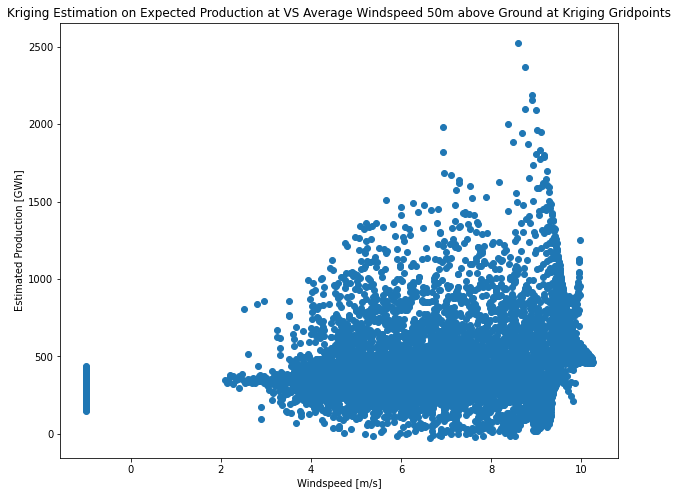

In [141]:
plt.figure(figsize=(10,8))
plt.scatter(kriging_wind,X_est_ok.flatten())
plt.xlabel('Windspeed [m/s]')
plt.ylabel('Estimated Production [GWh]')
plt.title('Kriging Estimation on Expected Production at VS Average Windspeed 50m above Ground at Kriging Gridpoints')
plt.show()

#### Correlation of Average Windspeed and Kriging Estimation on Expected Production at Kriging Gridpoints

In [142]:
print('Correlation Matrix:',np.corrcoef(kriging_wind,X_est_ok.flatten()))

Correlation Matrix: [[1.         0.21851181]
 [0.21851181 1.        ]]


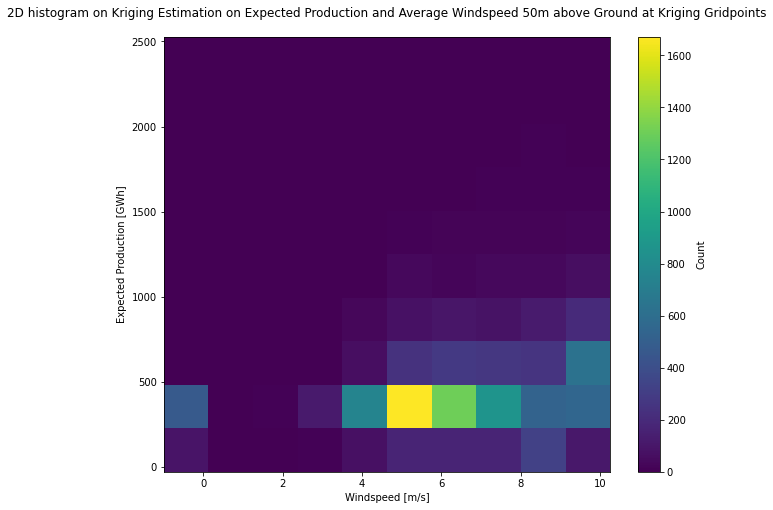

In [143]:
plt.figure(figsize=(10,8))
plt.hist2d(kriging_wind,X_est_ok.flatten())
plt.colorbar(label='Count')
plt.title('2D histogram on Kriging Estimation on Expected Production and Average Windspeed 50m above Ground at Kriging Gridpoints',pad=20)
plt.xlabel('Windspeed [m/s]')
plt.ylabel('Expected Production [GWh]')
plt.show()

### Combine Kriging Estimation and Average Windspeeds with Sensitivity Analysis on weighting of the Wind Factor

0                                                                          

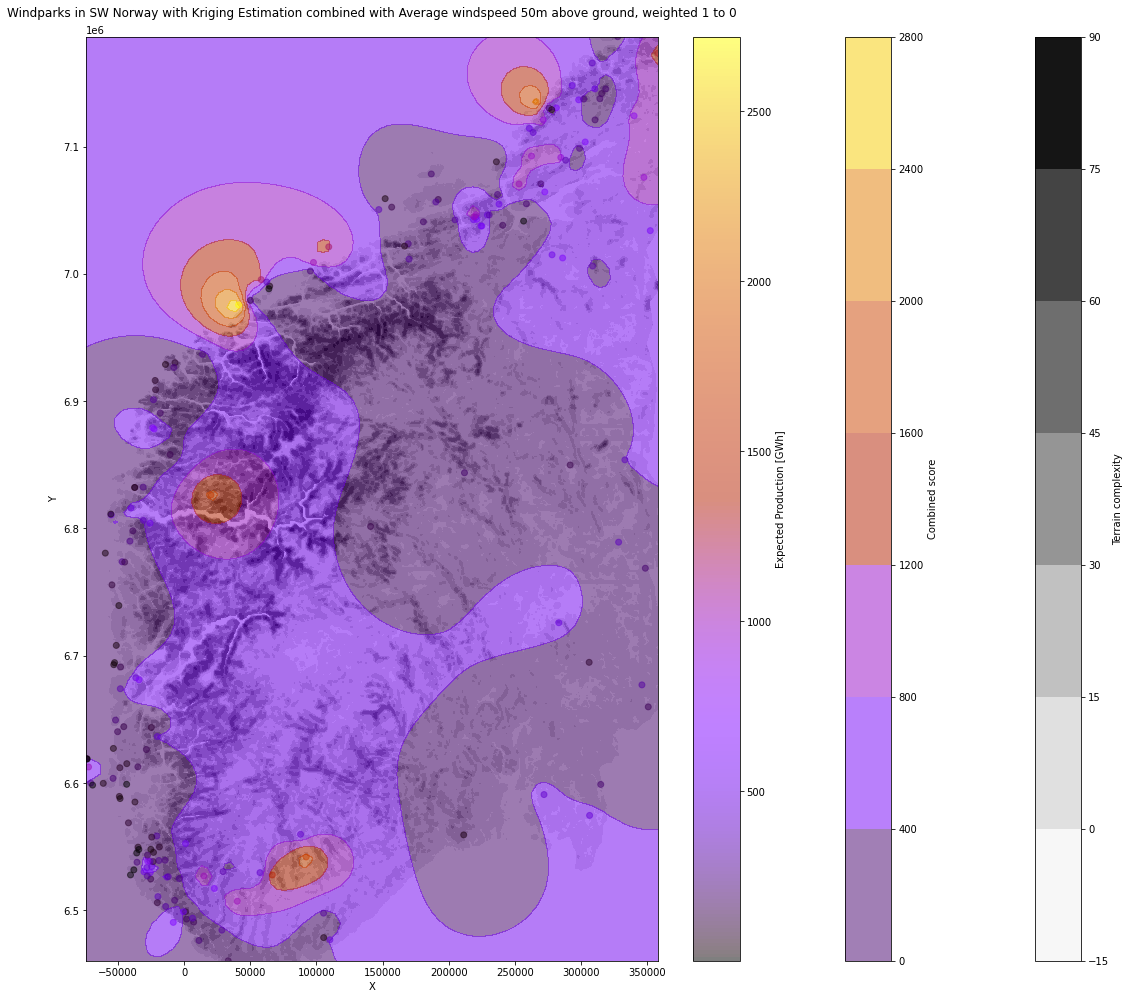

10                                                                          

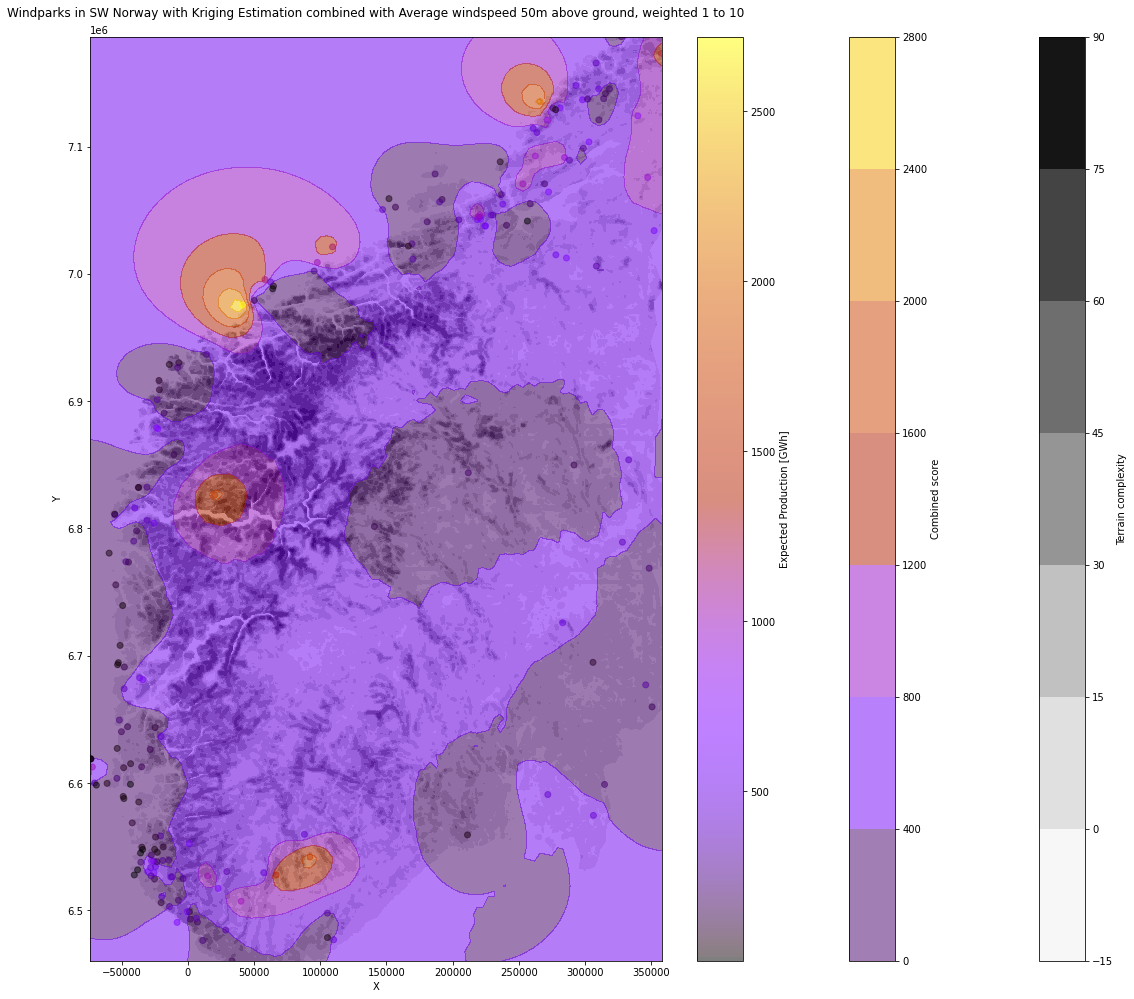

20                                                                          

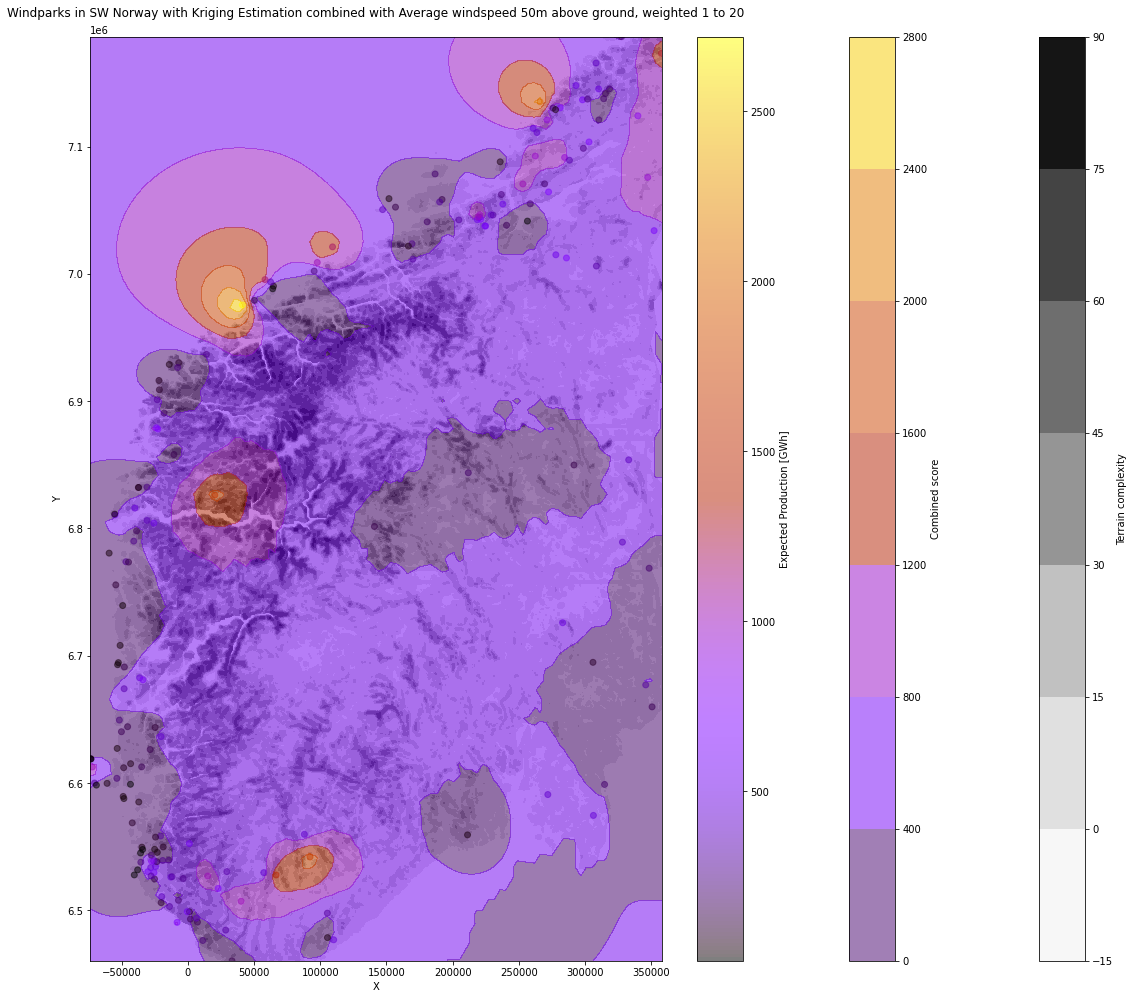

50                                                                          

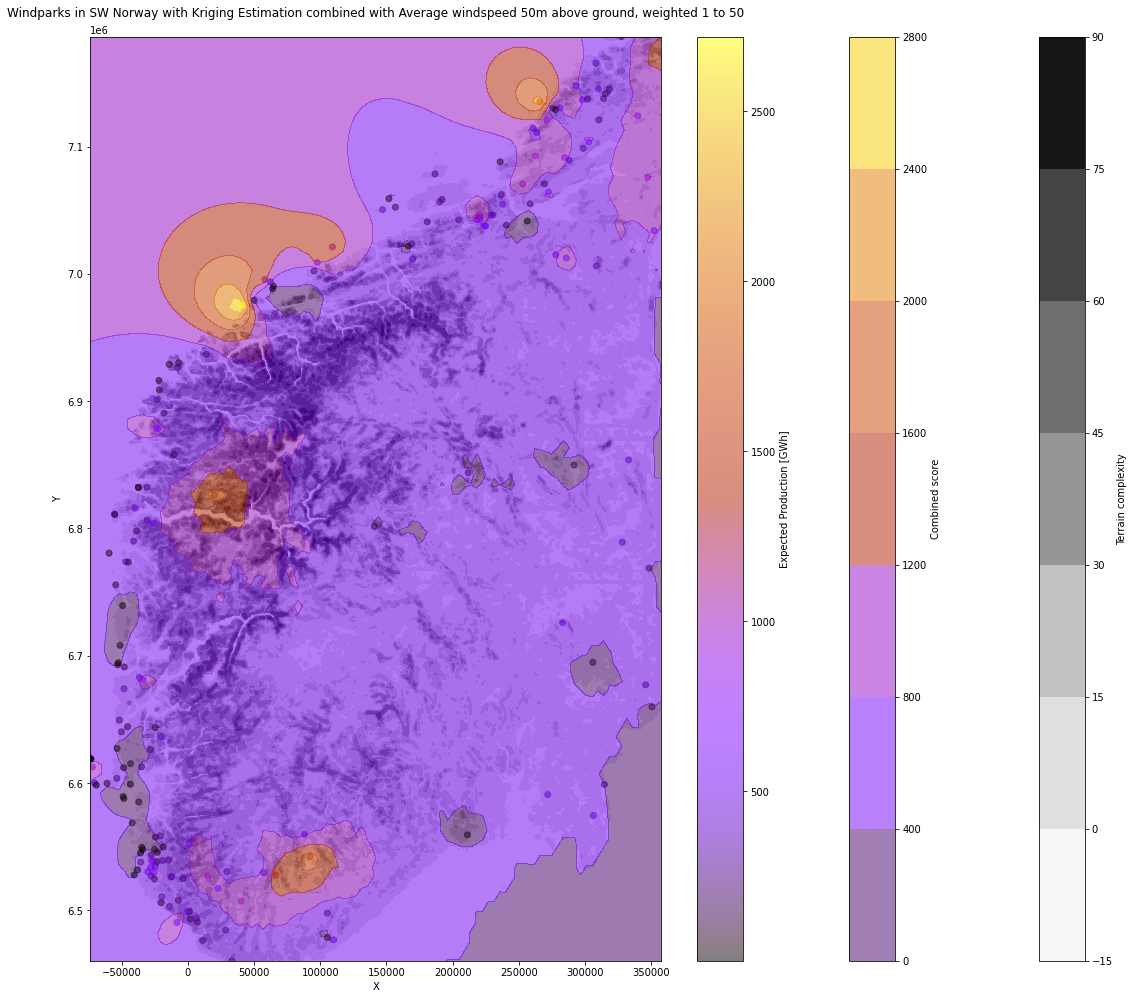

100                                                                          

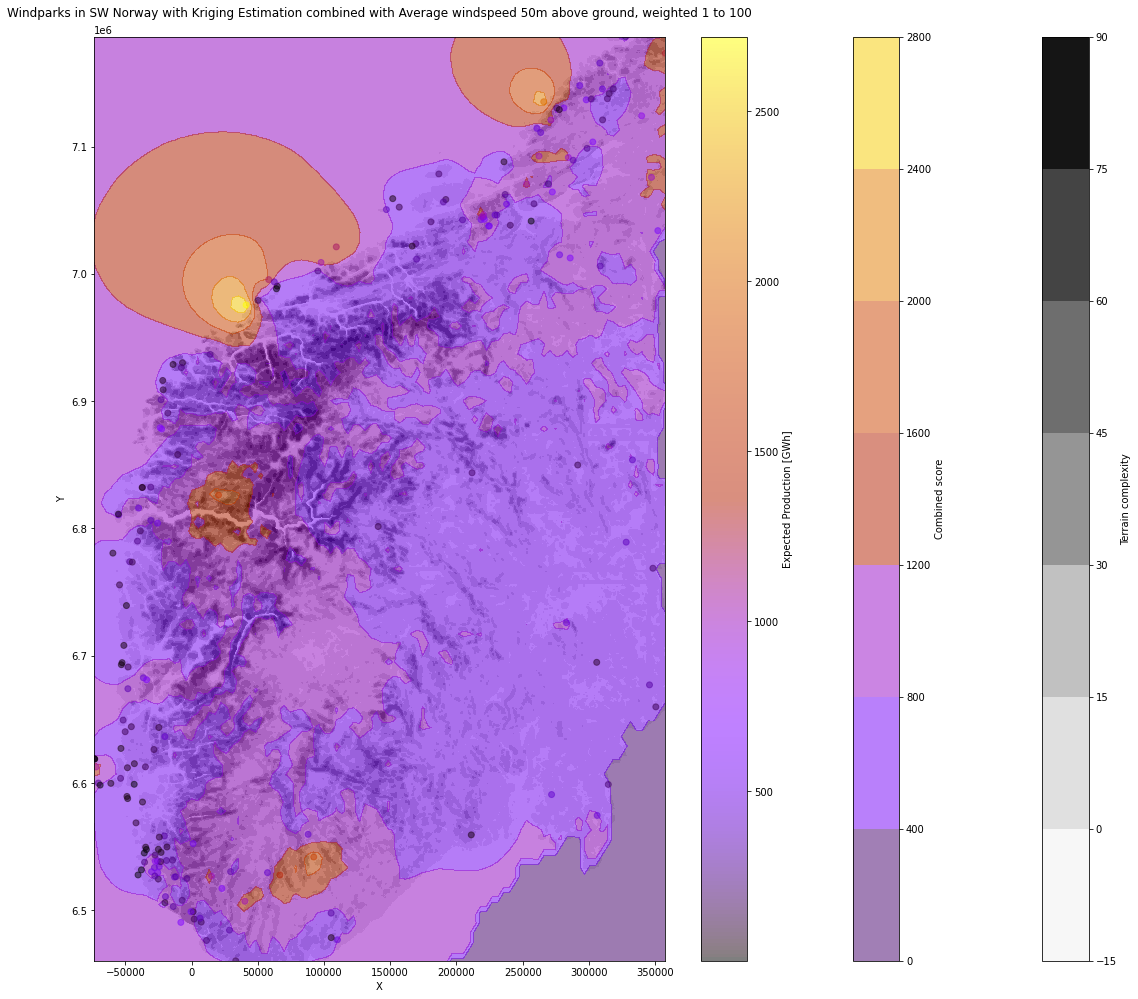

200                                                                          

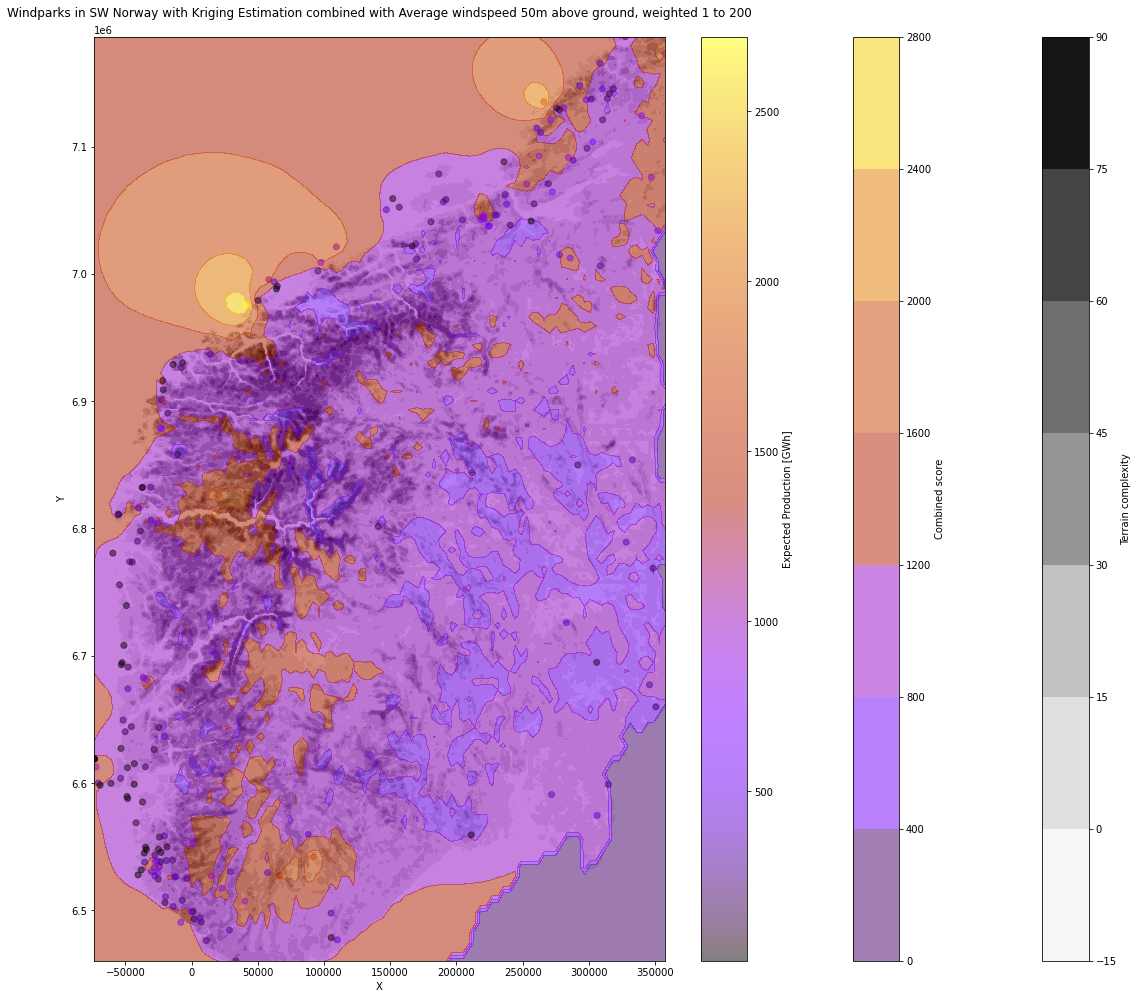

500                                                                          

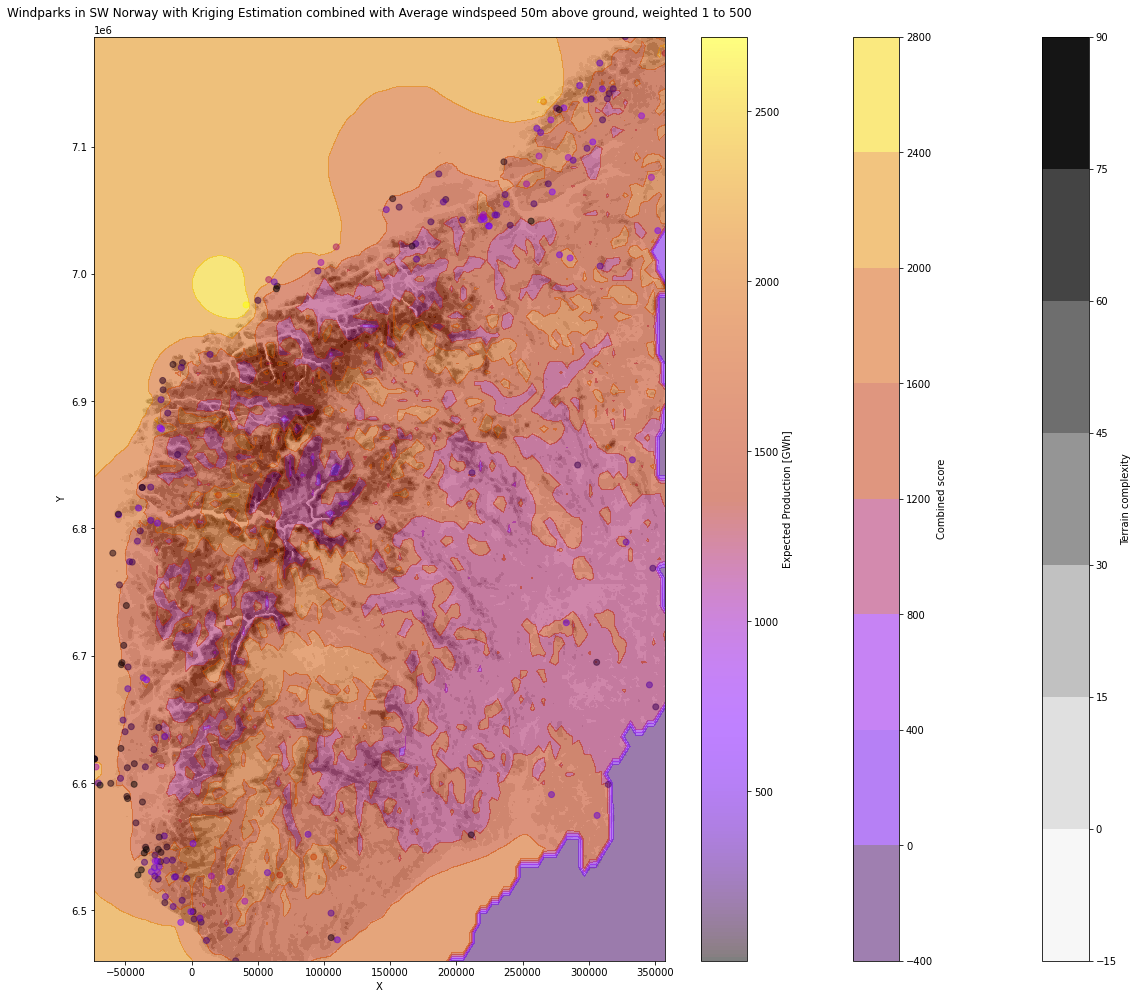

In [144]:
kriging_weight = 1
wind_weights = [0,10,20,50,100,200,500]
for wind_weight in wind_weights:
    sys.stdout.write('\r')
    sys.stdout.write(str(wind_weight)+'                                                                          ')
    sys.stdout.flush()

    combined = kriging_weight*np.reshape(X_est_ok_adjusted.flatten(),(nx_num,ny_num),order='F')+wind_weight*np.reshape(kriging_wind,(nx_num,ny_num),order='C')
    combined = np.max(vindkraft['forventetProduksjon_Gwh'])*combined/np.max(combined)

    plt.figure(figsize=(20,17))
    plt.contourf(Terrengkompleksitet.columns,Terrengkompleksitet.index, np.array(Terrengkompleksitet),alpha=1,cmap='Greys')
    plt.colorbar(label='Terrain complexity')

    plt.xlim(nx_low,nx_high)
    plt.ylim(ny_low,ny_high)

    plt.contourf(u_x,u_y,combined,alpha=0.5,cmap='gnuplot')
    plt.colorbar(label='Combined score')

    plt.scatter(vindkraft['X'],vindkraft['Y'],c=vindkraft['forventetProduksjon_Gwh'],alpha=0.5,cmap='gnuplot')
    plt.colorbar(label='Expected Production [GWh]')

    plt.title('Windparks in SW Norway with Kriging Estimation combined with Average windspeed 50m above ground, weighted '+ str(kriging_weight) +' to '+ str(wind_weight),pad=20)
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.show()